# Issue #24 calidad respuesta contra `DEPENDENCIA` y algunas variables con tiempo.

Este notebook responde las siguientes interrogantes:

Análisis estadístico entre calidades de respuesta.

* Qué dependencias tienen discrepancia entre ambas variables? Se concentran en alguna dependencia?
* En qué fechas hay más incidentes de discrepancias de ambas variables?
* Qué fechas+dependencias concentran estas discrepancias?

In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(".."))

In [2]:
import time
import boto3
import pyarrow
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src import eda as eda
from src import fixdependencia as fixdependencia

## Importamos datos raw

Definimos el bucket de la S3 y el folder donde ese encuentra el archivo inai.parquet que importaremos con la información de 2012 a 2019.

In [3]:
bucket = 'inai-summerofdata'
folder = 'mlpreproc'

In [5]:
f = f's3://{bucket}/{folder}/inai.parquet'
df = pd.read_parquet(f, engine='pyarrow')
#df = df[df['TIPOSOLICITUD']=='Información Pública']
original = df.copy()
df.head()

,folio,fechasolicitud,dependencia,estatus,medioentrada,tiposolicitud,descripcionsolicitud,otrosdatos,archivoadjuntosolicitud,medioentrega,...,estado,municipio,codigopostal,sector,tipo_archivo_respuesta,cantidad_archivos_respuesta,texto_respuesta_adjunto,respuestareal,calidad_respuesta,calidad_respuesta_real
0,1857500001912,2012-01-01 05:04:07,pemex exploracion y produccion,terminada,electronica,informacion publica,copia de los documentos y los con que cuenta a...,None,None,entrega por internet en el infomex,...,distrito federal,benito juarez,3100,energia,pdf,1.0,pemex exploracion y produccion oficio fecha 02...,entrega de informacion en medio electronico,satisfactoria,satisfactoria
1,1857500002012,2012-01-01 05:13:16,pemex exploracion y produccion,terminada,electronica,informacion publica,del informacion y usados en la de flujo de efe...,None,None,entrega por internet en el infomex,...,distrito federal,benito juarez,3100,energia,pdf,1.0,pemex exploracion y produccion oficio fecha 01...,entrega de informacion en medio electronico,satisfactoria,satisfactoria
2,0001800000712,2012-01-01 09:46:39,secretaria de energia,terminada,electronica,informacion publica,se me proporcione en magnetico y por este medi...,None,None,entrega por internet en el infomex,...,distrito federal,miguel hidalgo,11230,energia,zip,2.0,None,inexistencia de la informacion solicitada,no respondida,no respondida
3,0000600003712,2012-01-01 10:11:41,secretaria de hacienda y credito publico,terminada,electronica,informacion publica,se me proporcione en magnetico y por este medi...,None,None,entrega por internet en el infomex,...,distrito federal,miguel hidalgo,11230,hacienda y credito publico,pdf,1.0,inidos secretaria de hacienda y credito public...,la informacion esta disponible publicamente,satisfactoria,satisfactoria
4,0001500002812,2012-01-01 10:32:15,secretaria de desarrollo agrario territorial y...,terminada,electronica,informacion publica,se me proporcione en magnetico y por este medi...,None,None,entrega por internet en el infomex,...,distrito federal,miguel hidalgo,11230,reforma agraria,zip,4.0,None,sin respuesta,satisfactoria,no respondida


Guardamos el dataset limpio en otra variable `df1`

In [10]:
df1 = original.copy()

Importamos el data frame sin limpiar

In [11]:
bucket = 'inai-summerofdata'
folder = 'parquet'

In [12]:
f = f's3://{bucket}/{folder}/inai.parquet'
df = pd.read_parquet(f, engine='pyarrow')
df = df[df['TIPOSOLICITUD']=='Información Pública']
original_viejo = df.copy()
df.head()

,FOLIO,FECHASOLICITUD,DEPENDENCIA,ESTATUS,MEDIOENTRADA,TIPOSOLICITUD,DESCRIPCIONSOLICITUD,OTROSDATOS,ARCHIVOADJUNTOSOLICITUD,MEDIOENTREGA,...,ARCHIVORESPUESTA,FECHARESPUESTA,PAIS,ESTADO,MUNICIPIO,CODIGOPOSTAL,SECTOR,tipo_archivo_respuesta,cantidad_archivos_respuesta,texto_respuesta_adjunto
0,1857500001912,2012/01/01 05:04:07,PEMEX EXPLORACIÓN Y PRODUCCIÓN,Terminada,Electrónica,Información Pública,Copia de los documentos y los datos con que cu...,None,None,Entrega por Internet en el INFOMEX,...,https://www.infomex.org.mx/gobiernofederal/mod...,2012/03/02,México,Distrito Federal,BENITO JUAREZ,3100,Energía,pdf,1.0,PEMEX EXPLORACION Y PRODUCCION Oficio Fecha 0...
1,1857500002012,2012/01/01 05:13:16,PEMEX EXPLORACIÓN Y PRODUCCIÓN,Terminada,Electrónica,Información Pública,Del ATG para precisar información y datos usa...,None,None,Entrega por Internet en el INFOMEX,...,https://www.infomex.org.mx/gobiernofederal/mod...,2012/03/02,México,Distrito Federal,BENITO JUAREZ,3100,Energía,pdf,1.0,PEMEX EXPLORACION Y PRODUCCION Oficio Fecha 0...
2,0001800000712,2012/01/01 09:46:39,SECRETARÍA DE ENERGÍA,Terminada,Electrónica,Información Pública,Agradeceré se me proporcione en archivo magnét...,None,None,Entrega por Internet en el INFOMEX,...,https://www.infomex.org.mx/gobiernofederal/mod...,2012/02/02,México,Distrito Federal,MIGUEL HIDALGO,11230,Energía,zip,2.0,None
3,0000600003712,2012/01/01 10:11:41,SECRETARÍA DE HACIENDA Y CRÉDITO PÚBLICO,Terminada,Electrónica,Información Pública,Agradeceré se me proporcione en archivo magnét...,None,None,Entrega por Internet en el INFOMEX,...,https://www.infomex.org.mx/gobiernofederal/mod...,2012/02/02,México,Distrito Federal,MIGUEL HIDALGO,11230,Hacienda y Crédito Público,pdf,1.0,INIDOS SECRETARIA DE HACIENDA Y CREDITO PUBLI...
4,0001500002812,2012/01/01 10:32:15,SECRETARÍA DE DESARROLLO AGRARIO TERRITORIAL ...,Terminada,Electrónica,Información Pública,Agradeceré se me proporcione en archivo magnét...,None,None,Entrega por Internet en el INFOMEX,...,https://www.infomex.org.mx/gobiernofederal/mod...,2012/02/01,México,Distrito Federal,MIGUEL HIDALGO,11230,Reforma Agraria,zip,4.0,None


arreglamos las dependencias en el anterior data set

In [13]:
df = fixdependencia.FixDependencia(df)

Extraemos las columnas de dependencia_clean y Folio

In [15]:
df_extraccion = df[['FOLIO', 'dependencia_clean']]

Hacemos el merge de la columna dependencia_clean con el dataframe limpio 

In [16]:
para_union_nuevo = df1.copy()
para_union_viejo = df.copy()

In [22]:
data = [df_extraccion["FOLIO"], df_extraccion["dependencia_clean"]]

headers = ["FOLIO", "dependencia_clean"]

df3 = pd.concat(data, axis=1, keys=headers)
df3.head()

,FOLIO,dependencia_clean
0,1857500001912,pemex
1,1857500002012,pemex
2,0001800000712,sener
3,0000600003712,shcp
4,0001500002812,sedatu


In [28]:
df1.head()

,folio,fechasolicitud,dependencia,estatus,medioentrada,tiposolicitud,descripcionsolicitud,otrosdatos,archivoadjuntosolicitud,medioentrega,...,estado,municipio,codigopostal,sector,tipo_archivo_respuesta,cantidad_archivos_respuesta,texto_respuesta_adjunto,respuestareal,calidad_respuesta,calidad_respuesta_real
0,1857500001912,2012-01-01 05:04:07,pemex exploracion y produccion,terminada,electronica,informacion publica,copia de los documentos y los con que cuenta a...,None,None,entrega por internet en el infomex,...,distrito federal,benito juarez,3100,energia,pdf,1.0,pemex exploracion y produccion oficio fecha 02...,entrega de informacion en medio electronico,satisfactoria,satisfactoria
1,1857500002012,2012-01-01 05:13:16,pemex exploracion y produccion,terminada,electronica,informacion publica,del informacion y usados en la de flujo de efe...,None,None,entrega por internet en el infomex,...,distrito federal,benito juarez,3100,energia,pdf,1.0,pemex exploracion y produccion oficio fecha 01...,entrega de informacion en medio electronico,satisfactoria,satisfactoria
2,0001800000712,2012-01-01 09:46:39,secretaria de energia,terminada,electronica,informacion publica,se me proporcione en magnetico y por este medi...,None,None,entrega por internet en el infomex,...,distrito federal,miguel hidalgo,11230,energia,zip,2.0,None,inexistencia de la informacion solicitada,no respondida,no respondida
3,0000600003712,2012-01-01 10:11:41,secretaria de hacienda y credito publico,terminada,electronica,informacion publica,se me proporcione en magnetico y por este medi...,None,None,entrega por internet en el infomex,...,distrito federal,miguel hidalgo,11230,hacienda y credito publico,pdf,1.0,inidos secretaria de hacienda y credito public...,la informacion esta disponible publicamente,satisfactoria,satisfactoria
4,0001500002812,2012-01-01 10:32:15,secretaria de desarrollo agrario territorial y...,terminada,electronica,informacion publica,se me proporcione en magnetico y por este medi...,None,None,entrega por internet en el infomex,...,distrito federal,miguel hidalgo,11230,reforma agraria,zip,4.0,None,sin respuesta,satisfactoria,no respondida


In [29]:
df.head()

,FOLIO,FECHASOLICITUD,DEPENDENCIA,ESTATUS,MEDIOENTRADA,TIPOSOLICITUD,DESCRIPCIONSOLICITUD,OTROSDATOS,ARCHIVOADJUNTOSOLICITUD,MEDIOENTREGA,...,FECHARESPUESTA,PAIS,ESTADO,MUNICIPIO,CODIGOPOSTAL,SECTOR,tipo_archivo_respuesta,cantidad_archivos_respuesta,texto_respuesta_adjunto,dependencia_clean
0,1857500001912,2012/01/01 05:04:07,PEMEX EXPLORACIÓN Y PRODUCCIÓN,Terminada,Electrónica,Información Pública,Copia de los documentos y los datos con que cu...,None,None,Entrega por Internet en el INFOMEX,...,2012/03/02,México,Distrito Federal,BENITO JUAREZ,3100,Energía,pdf,1.0,PEMEX EXPLORACION Y PRODUCCION Oficio Fecha 0...,pemex
1,1857500002012,2012/01/01 05:13:16,PEMEX EXPLORACIÓN Y PRODUCCIÓN,Terminada,Electrónica,Información Pública,Del ATG para precisar información y datos usa...,None,None,Entrega por Internet en el INFOMEX,...,2012/03/02,México,Distrito Federal,BENITO JUAREZ,3100,Energía,pdf,1.0,PEMEX EXPLORACION Y PRODUCCION Oficio Fecha 0...,pemex
2,0001800000712,2012/01/01 09:46:39,SECRETARÍA DE ENERGÍA,Terminada,Electrónica,Información Pública,Agradeceré se me proporcione en archivo magnét...,None,None,Entrega por Internet en el INFOMEX,...,2012/02/02,México,Distrito Federal,MIGUEL HIDALGO,11230,Energía,zip,2.0,None,sener
3,0000600003712,2012/01/01 10:11:41,SECRETARÍA DE HACIENDA Y CRÉDITO PÚBLICO,Terminada,Electrónica,Información Pública,Agradeceré se me proporcione en archivo magnét...,None,None,Entrega por Internet en el INFOMEX,...,2012/02/02,México,Distrito Federal,MIGUEL HIDALGO,11230,Hacienda y Crédito Público,pdf,1.0,INIDOS SECRETARIA DE HACIENDA Y CREDITO PUBLI...,shcp
4,0001500002812,2012/01/01 10:32:15,SECRETARÍA DE DESARROLLO AGRARIO TERRITORIAL ...,Terminada,Electrónica,Información Pública,Agradeceré se me proporcione en archivo magnét...,None,None,Entrega por Internet en el INFOMEX,...,2012/02/01,México,Distrito Federal,MIGUEL HIDALGO,11230,Reforma Agraria,zip,4.0,None,sedatu


In [30]:
df3.columns= df3.columns.str.lower()
df3.head()

,folio,dependencia_clean
0,1857500001912,pemex
1,1857500002012,pemex
2,0001800000712,sener
3,0000600003712,shcp
4,0001500002812,sedatu


In [31]:
df_nuevo = pd.merge(para_union_nuevo, df3, how='left', on=['folio', 'folio'])
df_nuevo.head()

,folio,fechasolicitud,dependencia,estatus,medioentrada,tiposolicitud,descripcionsolicitud,otrosdatos,archivoadjuntosolicitud,medioentrega,...,municipio,codigopostal,sector,tipo_archivo_respuesta,cantidad_archivos_respuesta,texto_respuesta_adjunto,respuestareal,calidad_respuesta,calidad_respuesta_real,dependencia_clean
0,1857500001912,2012-01-01 05:04:07,pemex exploracion y produccion,terminada,electronica,informacion publica,copia de los documentos y los con que cuenta a...,None,None,entrega por internet en el infomex,...,benito juarez,3100,energia,pdf,1.0,pemex exploracion y produccion oficio fecha 02...,entrega de informacion en medio electronico,satisfactoria,satisfactoria,pemex
1,1857500002012,2012-01-01 05:13:16,pemex exploracion y produccion,terminada,electronica,informacion publica,del informacion y usados en la de flujo de efe...,None,None,entrega por internet en el infomex,...,benito juarez,3100,energia,pdf,1.0,pemex exploracion y produccion oficio fecha 01...,entrega de informacion en medio electronico,satisfactoria,satisfactoria,pemex
2,0001800000712,2012-01-01 09:46:39,secretaria de energia,terminada,electronica,informacion publica,se me proporcione en magnetico y por este medi...,None,None,entrega por internet en el infomex,...,miguel hidalgo,11230,energia,zip,2.0,None,inexistencia de la informacion solicitada,no respondida,no respondida,sener
3,0000600003712,2012-01-01 10:11:41,secretaria de hacienda y credito publico,terminada,electronica,informacion publica,se me proporcione en magnetico y por este medi...,None,None,entrega por internet en el infomex,...,miguel hidalgo,11230,hacienda y credito publico,pdf,1.0,inidos secretaria de hacienda y credito public...,la informacion esta disponible publicamente,satisfactoria,satisfactoria,shcp
4,0001500002812,2012-01-01 10:32:15,secretaria de desarrollo agrario territorial y...,terminada,electronica,informacion publica,se me proporcione en magnetico y por este medi...,None,None,entrega por internet en el infomex,...,miguel hidalgo,11230,reforma agraria,zip,4.0,None,sin respuesta,satisfactoria,no respondida,sedatu


Queremos saber:
* Qué dependencias tienen discrepancia entre ambas variables? Se concentran en alguna dependencia?
* En qué fechas hay más incidentes de discrepancias de ambas variables?
* Qué fechas+dependencias concentran estas discrepancias?

In [32]:
pd.set_option('display.max_rows', None)
respuesta_vs_tipo_archivo = df_nuevo.groupby('calidad_respuesta')['dependencia_clean'].value_counts(dropna=False)
pd.DataFrame(respuesta_vs_tipo_archivo)

dependencia_clean
calidad_respuesta dependencia_clean                                                    
en proceso        sep                                                              7653
                  organismo descentralizado                                        4615
                  pgr                                                              4151
                  segob                                                            3696
                  ssa                                                              2851
                  instituto mexicano del seguro social (imss)                      2555
                  semarnat                                                         2357
                  shcp                                                             2317
                  profeco                                                          2146
                  cofepris                                                         1903
                  organismo autonomo                                               1817
                  sct                                                              1605
                  cfe                                                              1498
                  sat                                                              1322
                  sfp                                                              1259
                  stps                                                             1191
                  poder judicial de la federacion                                  1149
                  pemex                                                            1055
                  scjn                                                             1013
                  conacyt                                                           835
                  sre                                                               778
                  ipn                                                               774
                  hospitales                                                        700
                  ine                                                               675
                  empresas de participacion estatal                                 607
                  sedesol                                                           579
                  inai                                                              572
                  sedatu                                                            548
                  sagarpa                                                           510
                  se                                                                503
                  administracion portuaria integral                                 487
                  instituto del fondo nacional de la vivienda par...                446
                  registro agrario nacional                                         438
                  banca de desarrollo                                               432
                  unam                                                              432
                  tribunales administrativos                                        416
                  sedena                                                            404
                  sectur                                                            396
                  presidencia de la republica                                       373
                  policia federal                                                   368
                  cnbv                                                              359
                  secretaría de cultura                                             328
                  instituto nacional de migración                                   327
                  partidos politicos                                                325
                  audi

In [33]:
pd.set_option('display.max_rows', None)
respuesta_vs_tipo_archivo = df_nuevo.groupby('calidad_respuesta_real')['dependencia_clean'].value_counts(dropna=False)
pd.DataFrame(respuesta_vs_tipo_archivo)

dependencia_clean
calidad_respuesta_real dependencia_clean                                                    
en proceso             sep                                                              7653
                       organismo descentralizado                                        4615
                       pgr                                                              4151
                       segob                                                            3696
                       ssa                                                              2851
                       instituto mexicano del seguro social (imss)                      2555
                       semarnat                                                         2357
                       shcp                                                             2317
                       profeco                                                          2146
                       cofepris                                                         1903
                       organismo autonomo                                               1817
                       sct                                                              1605
                       cfe                                                              1498
                       sat                                                              1322
                       sfp                                                              1259
                       stps                                                             1191
                       poder judicial de la federacion                                  1149
                       pemex                                                            1055
                       scjn                                                             1013
                       conacyt                                                           835
                       sre                                                               778
                       ipn                                                               774
                       hospitales                                                        700
                       ine                                                               675
                       empresas de participacion estatal                                 607
                       sedesol                                                           579
                       inai                                                              572
                       sedatu                                                            548
                       sagarpa                                                           510
                       se                                                                503
                       administracion portuaria integral                                 487
                       instituto del fondo nacional de la vivienda par...                446
                       registro agrario nacional                                         438
                       banca de desarrollo                                               432
                       unam                                                              432
                       tribunales administrativos                                        416
                       sedena                                                            404
                       sectur                                                            396
                       presidencia de la republica                                       373
                       policia federal                                                   368
                       cnbv                                                              359
                       secretaría de cultura                                

Extraemos los 3 casos para las dos variables:
 * En proceso
 * No respondida
 * Satisfactoria

In [34]:
cr_proceso = df_nuevo[df_nuevo['calidad_respuesta']=='en proceso']
cr_no = df_nuevo[df_nuevo['calidad_respuesta']=='no respondida']
cr_si = df_nuevo[df_nuevo['calidad_respuesta']=='satisfactoria']
crr_proceso = df_nuevo[df_nuevo['calidad_respuesta_real']=='en proceso']
crr_no = df_nuevo[df_nuevo['calidad_respuesta_real']=='no respondida']
crr_si = df_nuevo[df_nuevo['calidad_respuesta_real']=='satisfactoria']

el caso satisfactorio:
cr_si y crr_si

In [38]:
eda.CreaTablaConteoPorcentaje(cr_si, 'dependencia_clean', booleanNA = False)

,dependencia_clean,porcentaje
instituto mexicano del seguro social (imss),65866,7.16%
sep,63174,6.87%
semarnat,54797,5.96%
ssa,50306,5.47%
organismo descentralizado,35300,3.84%
pemex,30855,3.35%
shcp,30472,3.31%
organismo autonomo,30468,3.31%
cofepris,28837,3.13%
sct,28349,3.08%


In [39]:
eda.CreaTablaConteoPorcentaje(crr_si, 'dependencia_clean', booleanNA = False)

,dependencia_clean,porcentaje
sep,44475,7.24%
ssa,38748,6.31%
instituto mexicano del seguro social (imss),29504,4.8%
cofepris,25661,4.18%
pemex,23372,3.81%
shcp,21729,3.54%
organismo descentralizado,20905,3.4%
organismo autonomo,20533,3.34%
semarnat,19260,3.14%
pgr,17868,2.91%


SEP, SSA e IMSS son las que tienen mayor proporcion en las respuestas satisfactorias realmente

Con las no respondidas: cr_no y crr_no

In [40]:
eda.CreaTablaConteoPorcentaje(cr_no, 'dependencia_clean', booleanNA = False)

,dependencia_clean,porcentaje
cofepris,22407,8.38%
pemex,18406,6.88%
semarnat,16867,6.31%
segob,15208,5.69%
sep,13740,5.14%
ssa,11854,4.43%
instituto mexicano del seguro social (imss),11423,4.27%
shcp,10003,3.74%
sfp,9540,3.57%
organismo autonomo,8582,3.21%


In [41]:
eda.CreaTablaConteoPorcentaje(crr_no, 'dependencia_clean', booleanNA = False)

,dependencia_clean,porcentaje
semarnat,52404,9.14%
instituto mexicano del seguro social (imss),47785,8.34%
sep,32439,5.66%
pemex,25889,4.52%
cofepris,25583,4.46%
ssa,23412,4.08%
sct,21335,3.72%
segob,21331,3.72%
cfe,19120,3.34%
shcp,18746,3.27%


En proceso

In [44]:
#eda.CreaTablaConteoPorcentaje(cr_proceso, 'dependencia_clean', booleanNA = False)

In [45]:
#eda.CreaTablaConteoPorcentaje(crr_proceso, 'dependencia_clean', booleanNA = False)

No cambian, lo cual tiene sentido si consideramos que no se tocaron en el algoritmo

In [48]:
df_nuevo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1249668 entries, 0 to 1249667
Data columns (total 27 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   folio                        1249668 non-null  object        
 1   fechasolicitud               1249668 non-null  datetime64[ns]
 2   dependencia                  1249668 non-null  object        
 3   estatus                      1249668 non-null  object        
 4   medioentrada                 1249668 non-null  object        
 5   tiposolicitud                1249668 non-null  object        
 6   descripcionsolicitud         1249668 non-null  object        
 7   otrosdatos                   1249668 non-null  object        
 8   archivoadjuntosolicitud      1249668 non-null  object        
 9   medioentrega                 1249668 non-null  object        
 10  fechalimite                  1138841 non-null  datetime64[ns]
 11  respuesta  

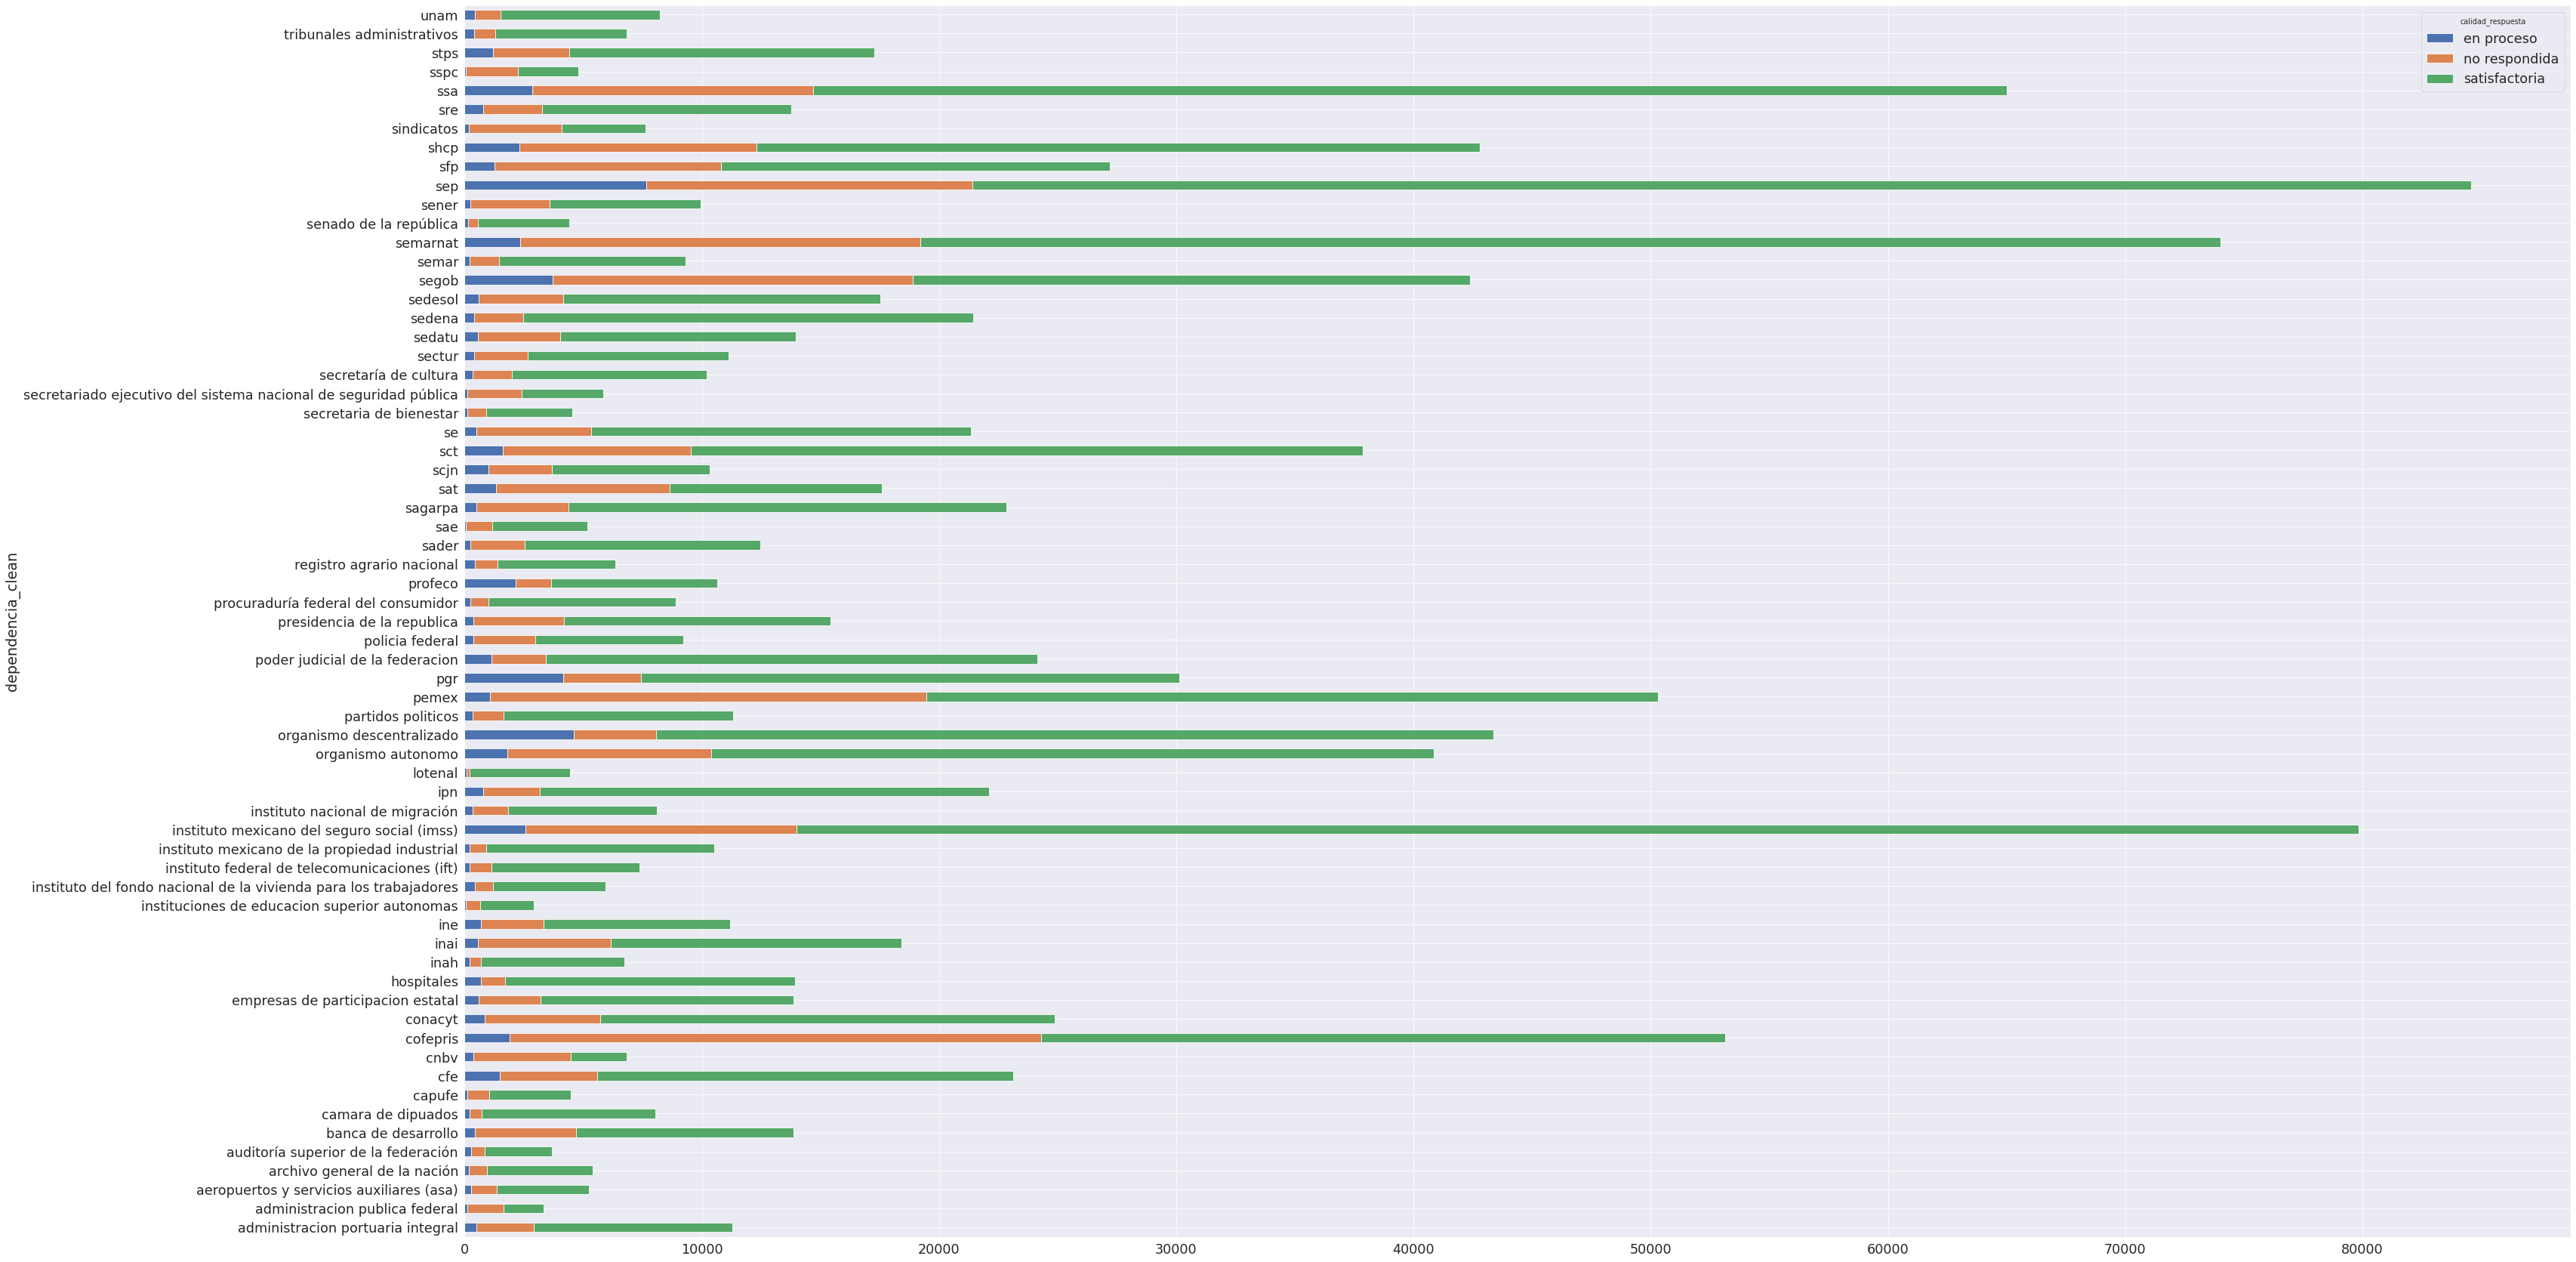

In [200]:
df_nuevo.groupby(['dependencia_clean', 'calidad_respuesta']).size().unstack().plot(kind='barh', stacked=True,figsize=(50,30))

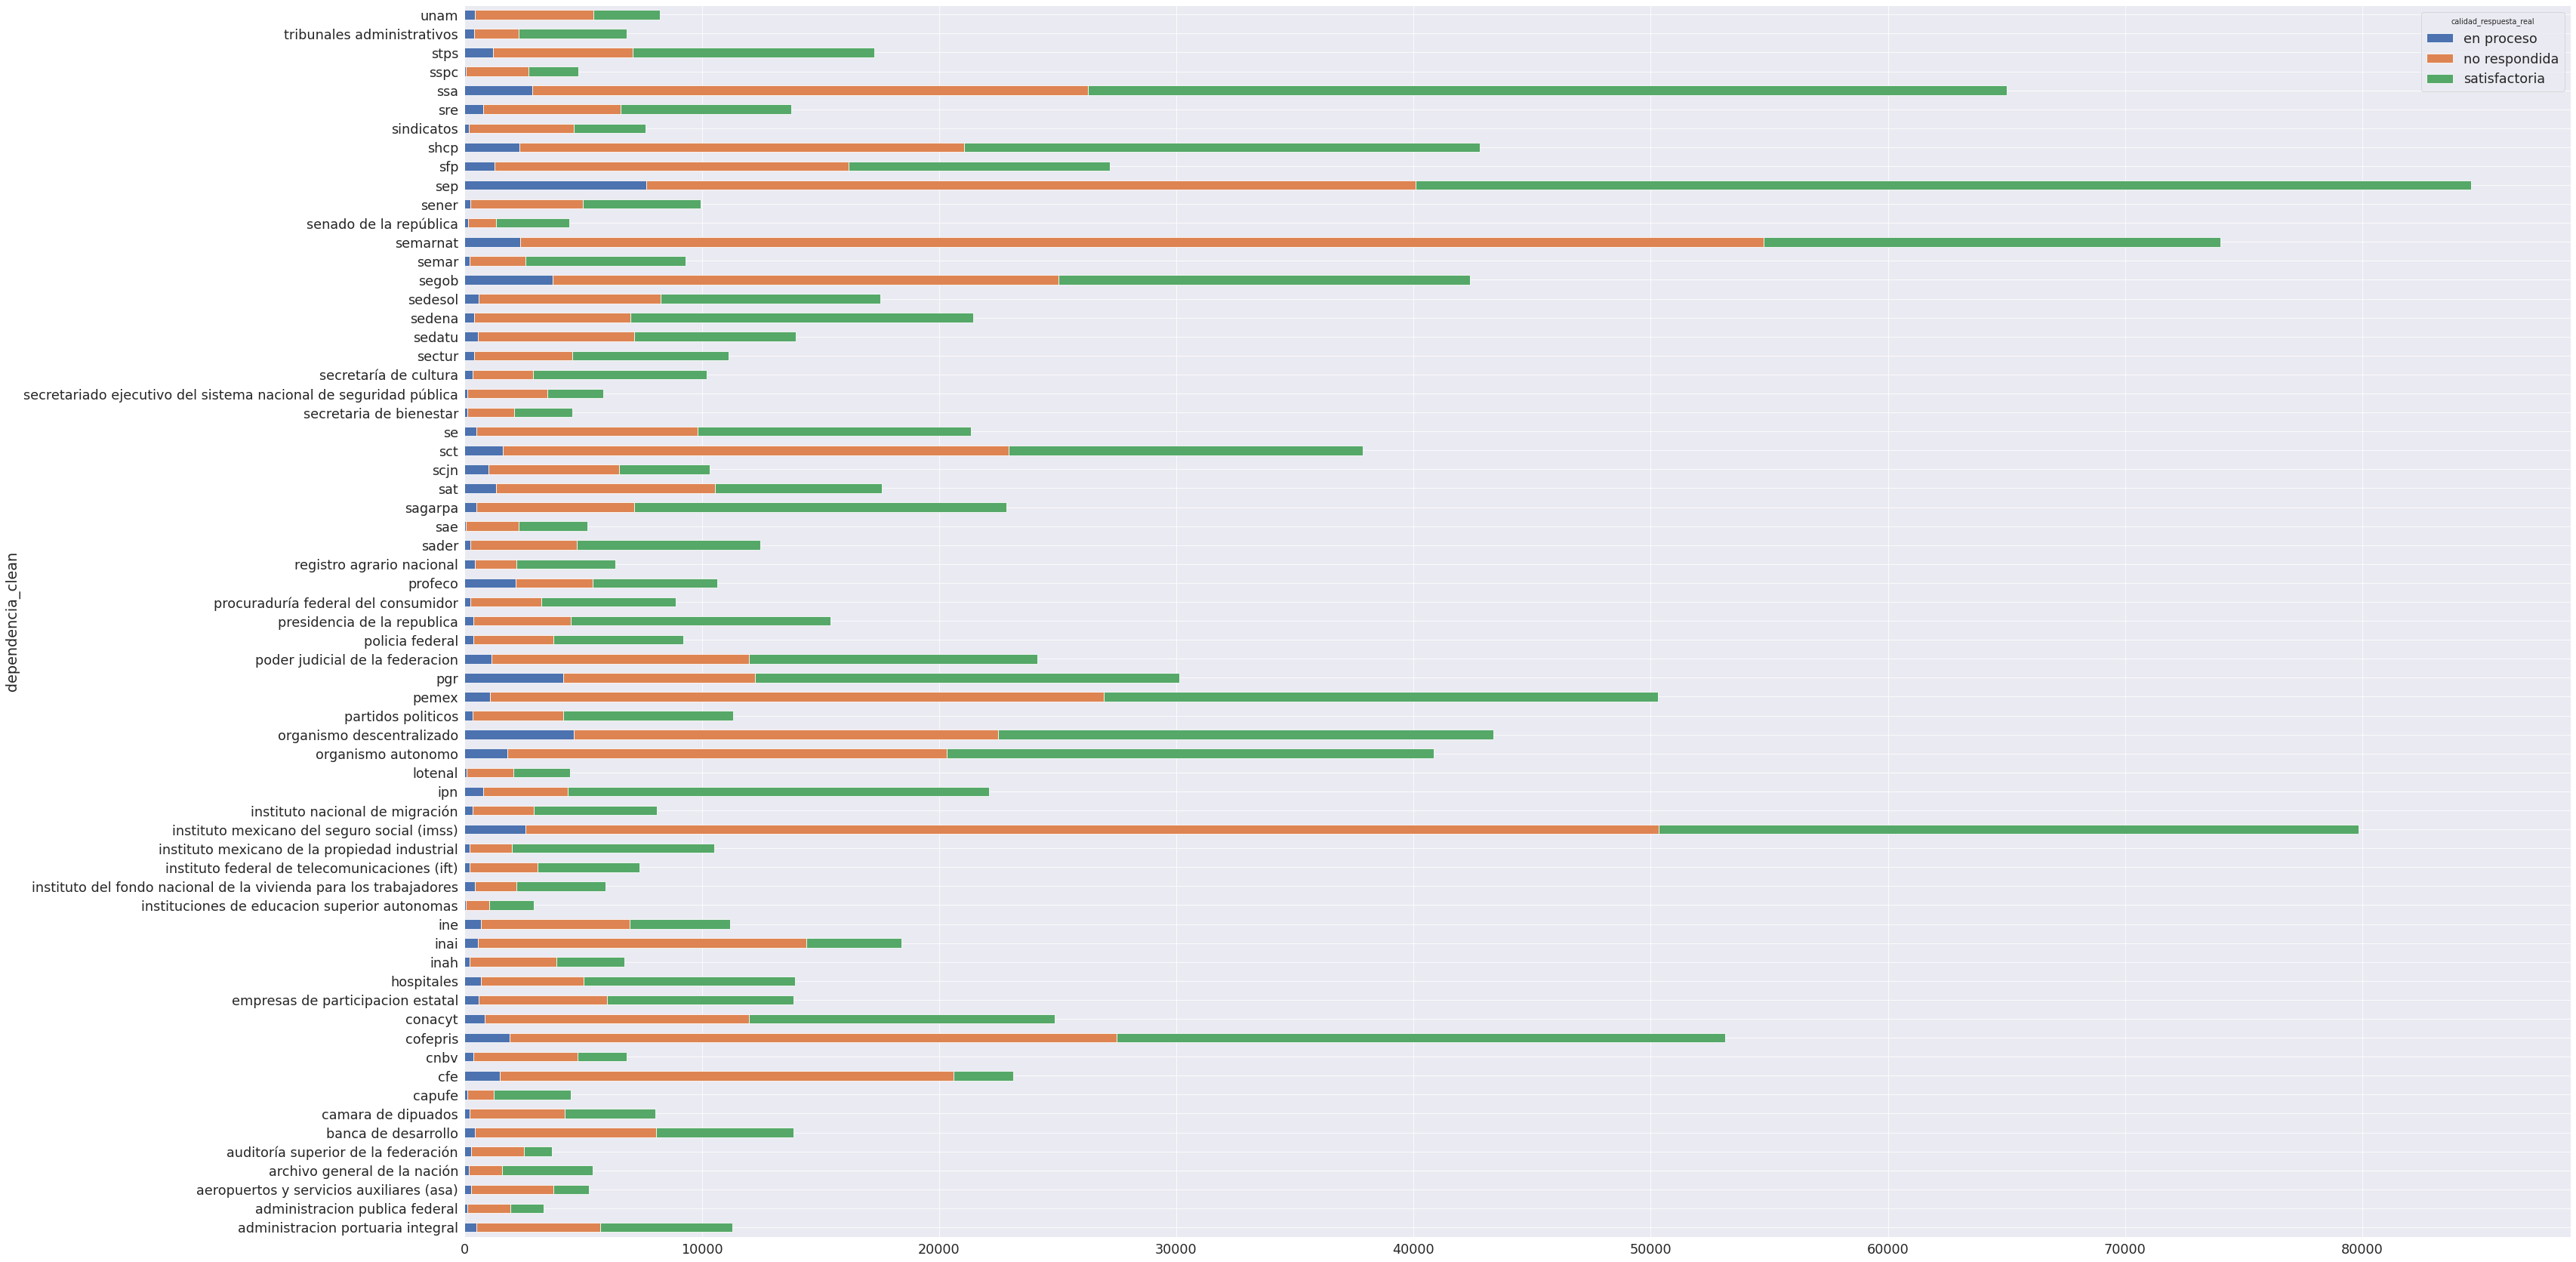

In [182]:

df_nuevo.groupby(['dependencia_clean', 'calidad_respuesta_real']).size().unstack().plot(kind='barh', stacked=True,figsize=(50,30))

In [202]:
pd.crosstab(df_nuevo['dependencia_clean'], df_nuevo['calidad_respuesta_real'])

calidad_respuesta_real,en proceso,no respondida,satisfactoria
dependencia_clean,,,
administracion portuaria integral,487,5228,5571
administracion publica federal,130,1803,1385
aeropuertos y servicios auxiliares (asa),283,3461,1508
archivo general de la nación,194,1397,3802
auditoría superior de la federación,284,2215,1187
banca de desarrollo,432,7649,5784
camara de dipuados,205,4005,3815
capufe,105,1133,3240
cfe,1498,19120,2510


In [55]:
pd.crosstab(df_nuevo['dependencia_clean'], df_nuevo['calidad_respuesta'])

calidad_respuesta,en proceso,no respondida,satisfactoria
dependencia_clean,,,
administracion portuaria integral,487,2424,8375
administracion publica federal,130,1502,1686
aeropuertos y servicios auxiliares (asa),283,1062,3907
archivo general de la nación,194,755,4444
auditoría superior de la federación,284,560,2842
banca de desarrollo,432,4262,9171
camara de dipuados,205,524,7296
capufe,105,948,3425
cfe,1498,4084,17546


## ¿y el tiempo?

In [115]:
df_nuevo['año_solicitud'] = pd.DatetimeIndex(df_nuevo['fechasolicitud']).year

In [116]:
df_nuevo['mes_solicitud'] = pd.DatetimeIndex(df_nuevo['fechasolicitud']).month

In [117]:
cr_proceso = df_nuevo[df_nuevo['calidad_respuesta']=='en proceso']
cr_no = df_nuevo[df_nuevo['calidad_respuesta']=='no respondida']
cr_si = df_nuevo[df_nuevo['calidad_respuesta']=='satisfactoria']
crr_proceso = df_nuevo[df_nuevo['calidad_respuesta_real']=='en proceso']
crr_no = df_nuevo[df_nuevo['calidad_respuesta_real']=='no respondida']
crr_si = df_nuevo[df_nuevo['calidad_respuesta_real']=='satisfactoria']

### El caso de los rechazos

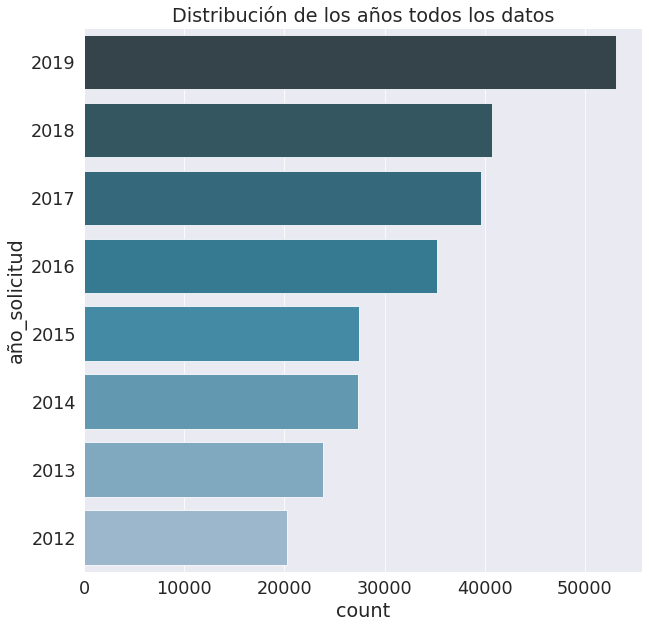

In [118]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(10, 10))
plt.title("Distribución de los años todos los datos")
ax = sns.countplot(y="año_solicitud", data=cr_no,order = cr_no['año_solicitud'].value_counts().index, palette="PuBuGn_d")

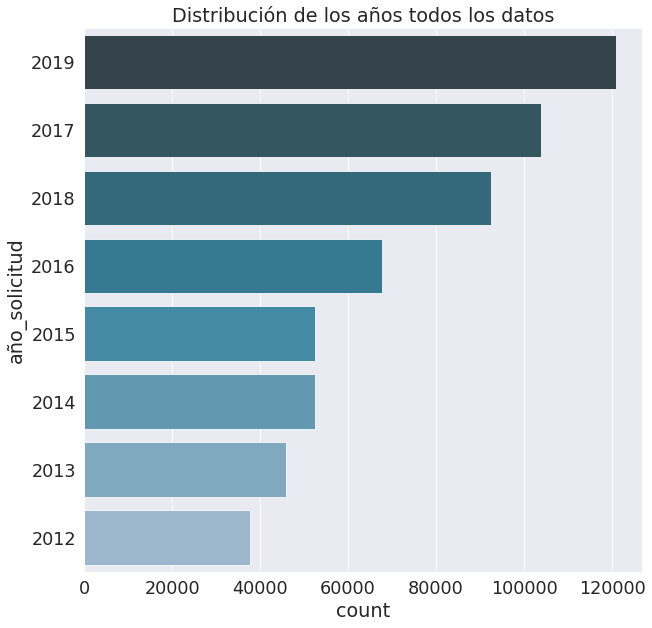

In [119]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(10, 10))
plt.title("Distribución de los años todos los datos")
ax = sns.countplot(y="año_solicitud", data=crr_no,order = crr_no['año_solicitud'].value_counts().index, palette="PuBuGn_d")

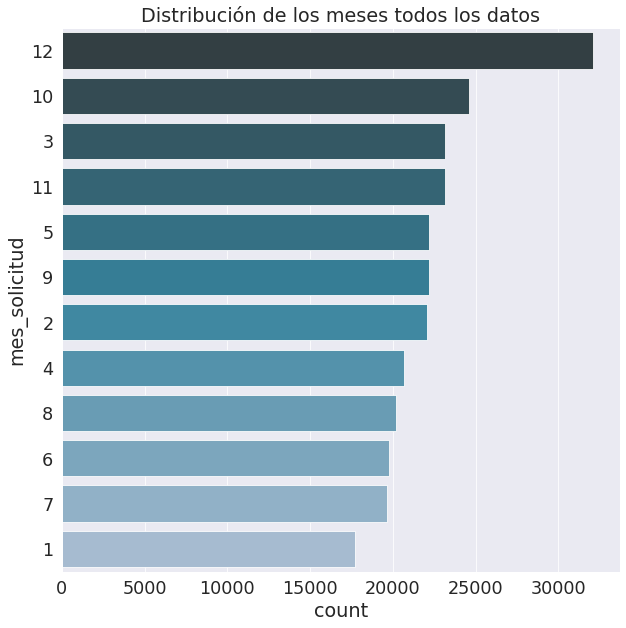

In [120]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(10, 10))
plt.title("Distribución de los meses todos los datos")
ax = sns.countplot(y="mes_solicitud", data=cr_no,order = cr_no['mes_solicitud'].value_counts().index, palette="PuBuGn_d")

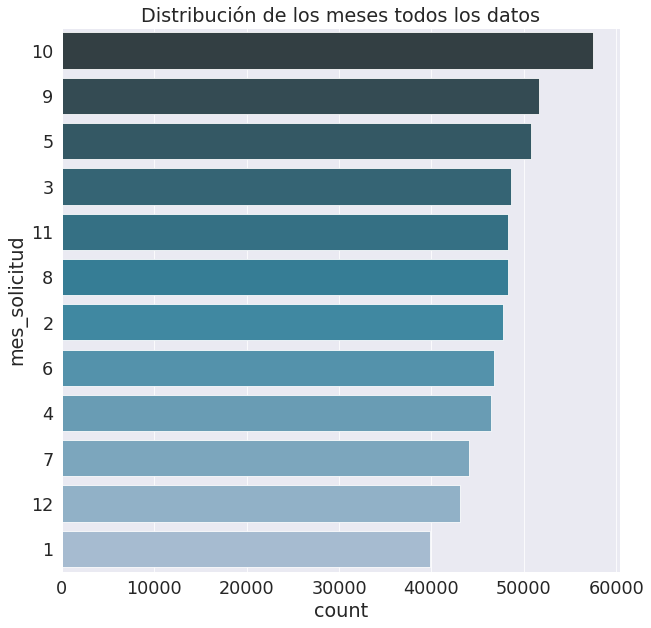

In [121]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(10, 10))
plt.title("Distribución de los meses todos los datos")
ax = sns.countplot(y="mes_solicitud", data=crr_no,order = crr_no['mes_solicitud'].value_counts().index, palette="PuBuGn_d")

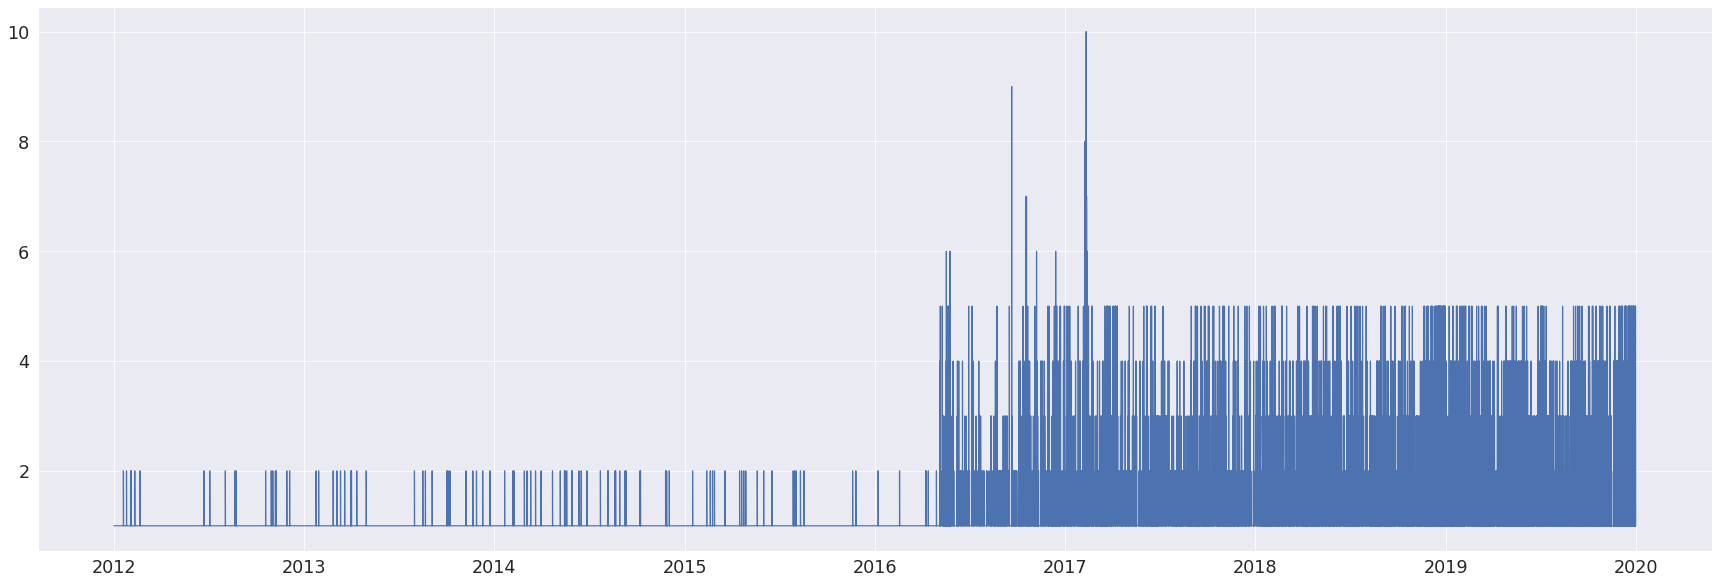

In [122]:
plt.figure(figsize=(30, 10))
plt.plot(cr_no['fechasolicitud'].value_counts().sort_index())

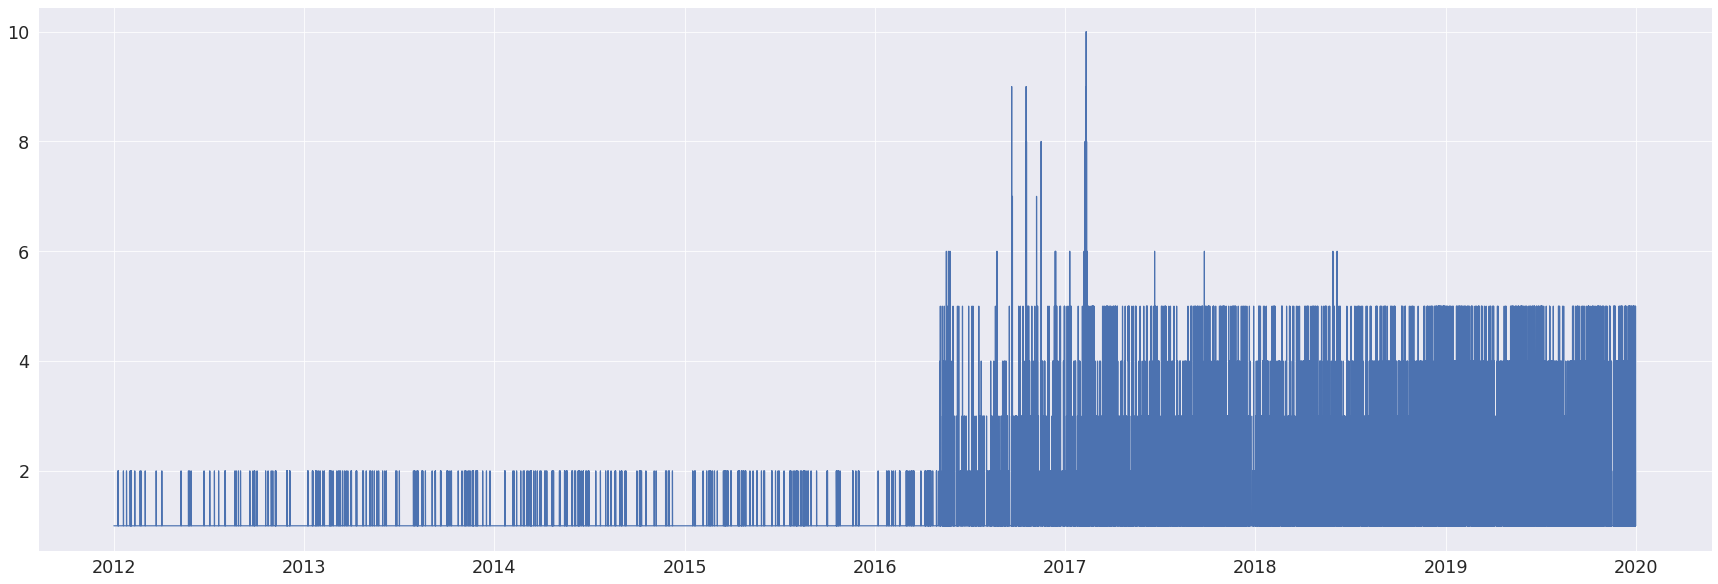

In [123]:
plt.figure(figsize=(30, 10))
plt.plot(crr_no['fechasolicitud'].value_counts().sort_index())

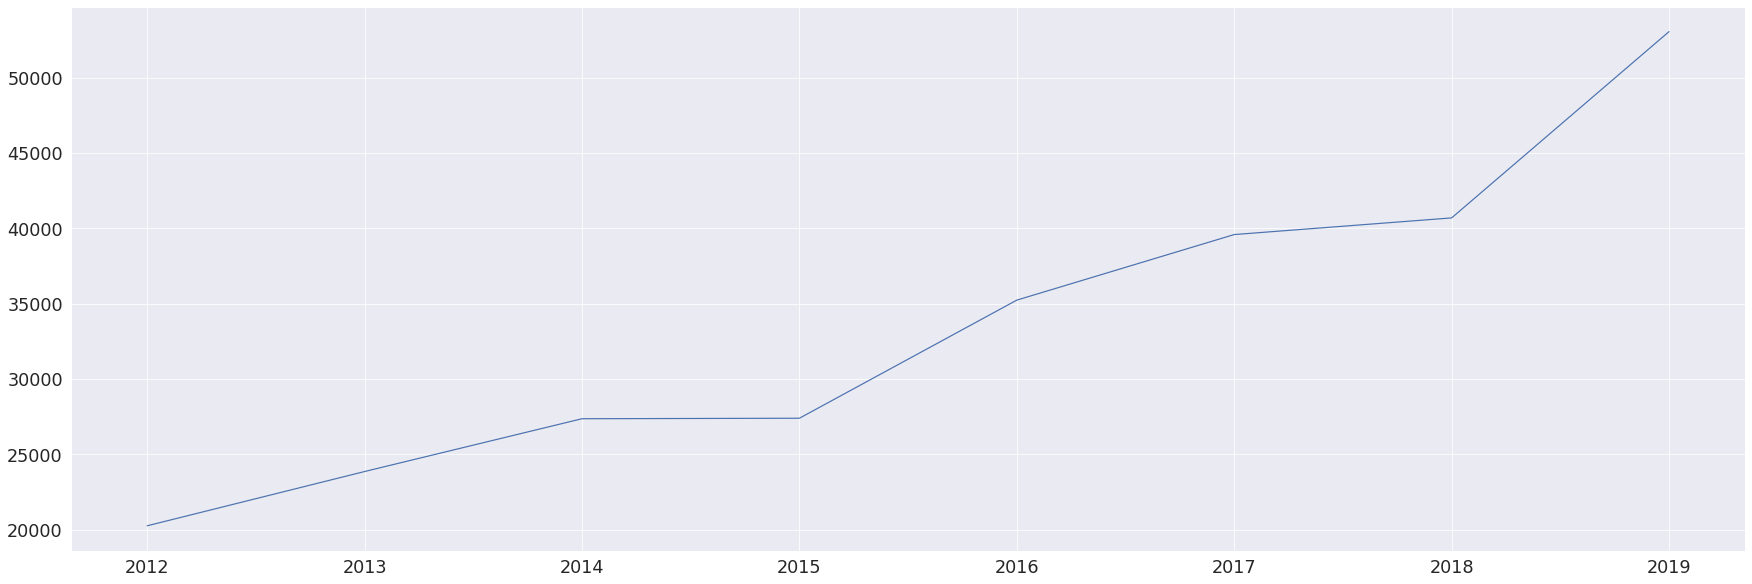

In [124]:
plt.figure(figsize=(30, 10))
plt.plot(cr_no['año_solicitud'].value_counts().sort_index())

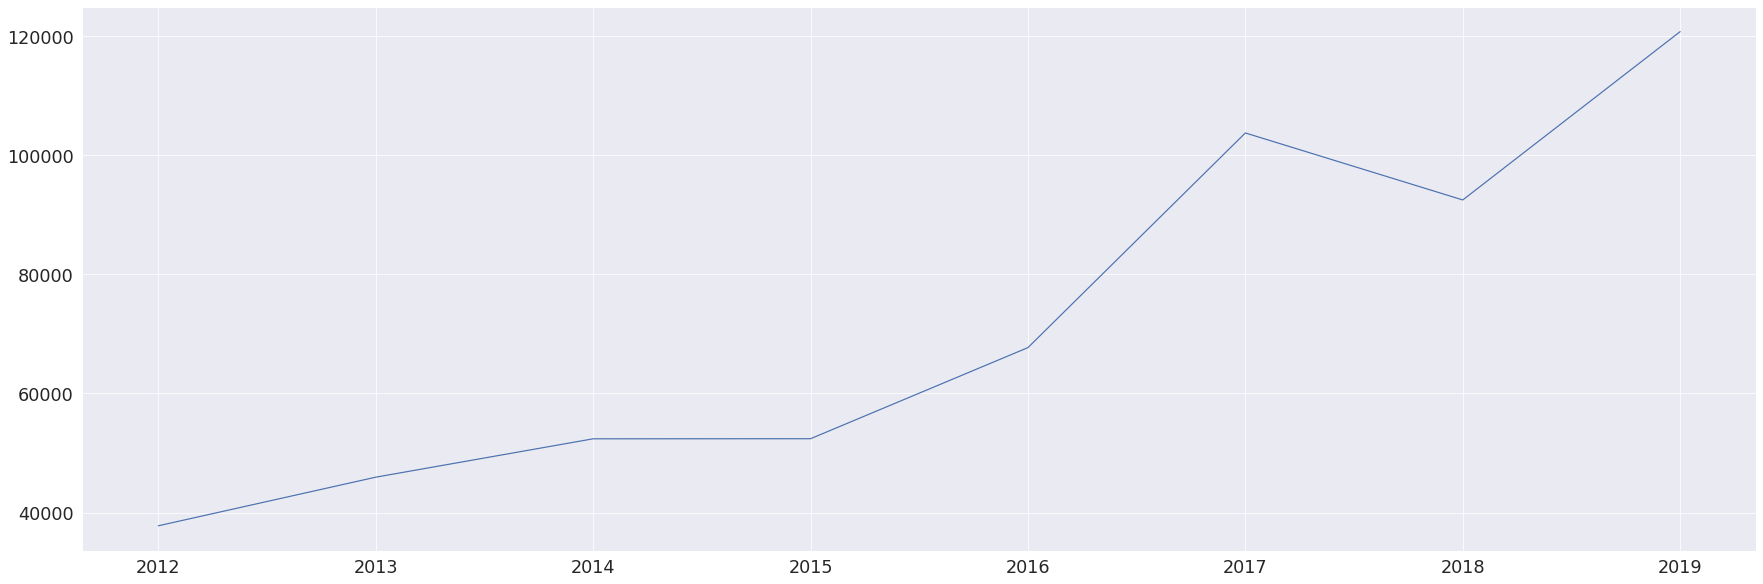

In [125]:
plt.figure(figsize=(30, 10))
plt.plot(crr_no['año_solicitud'].value_counts().sort_index())

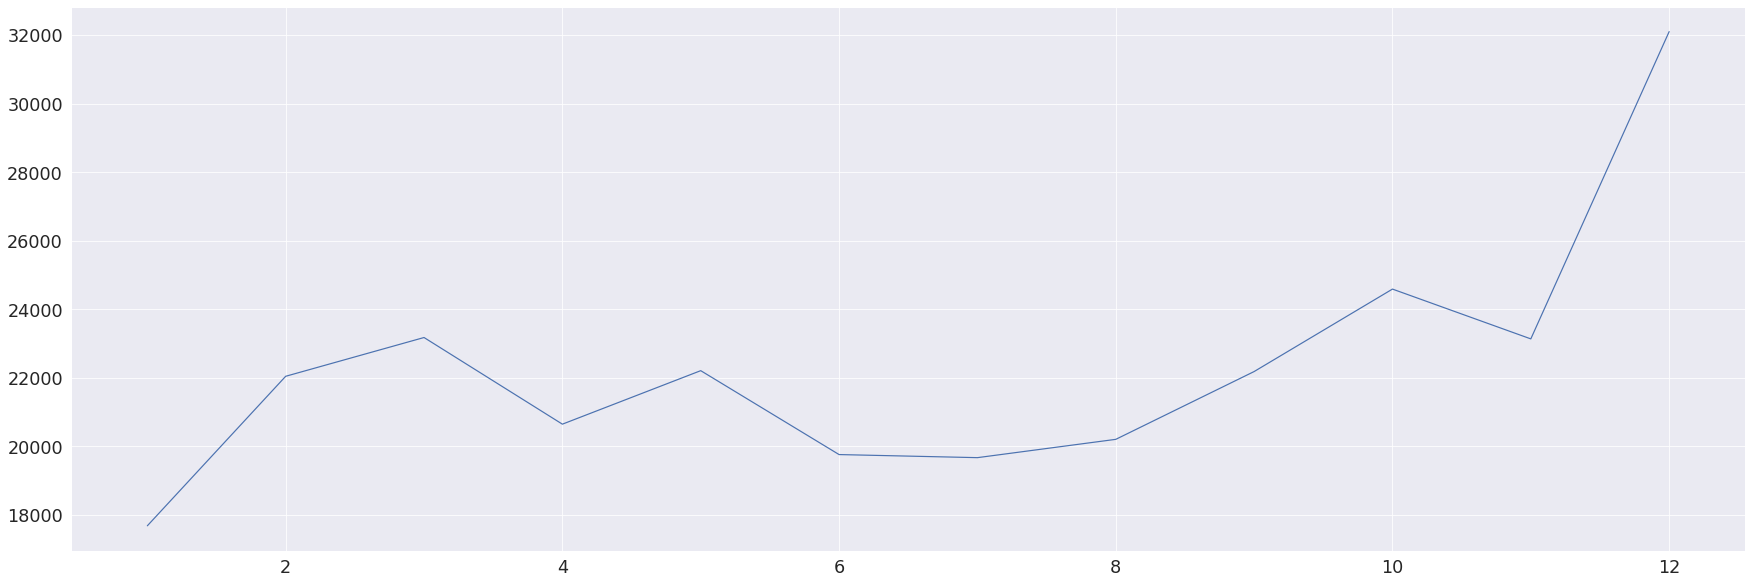

In [126]:
plt.figure(figsize=(30, 10))
plt.plot(cr_no['mes_solicitud'].value_counts().sort_index())

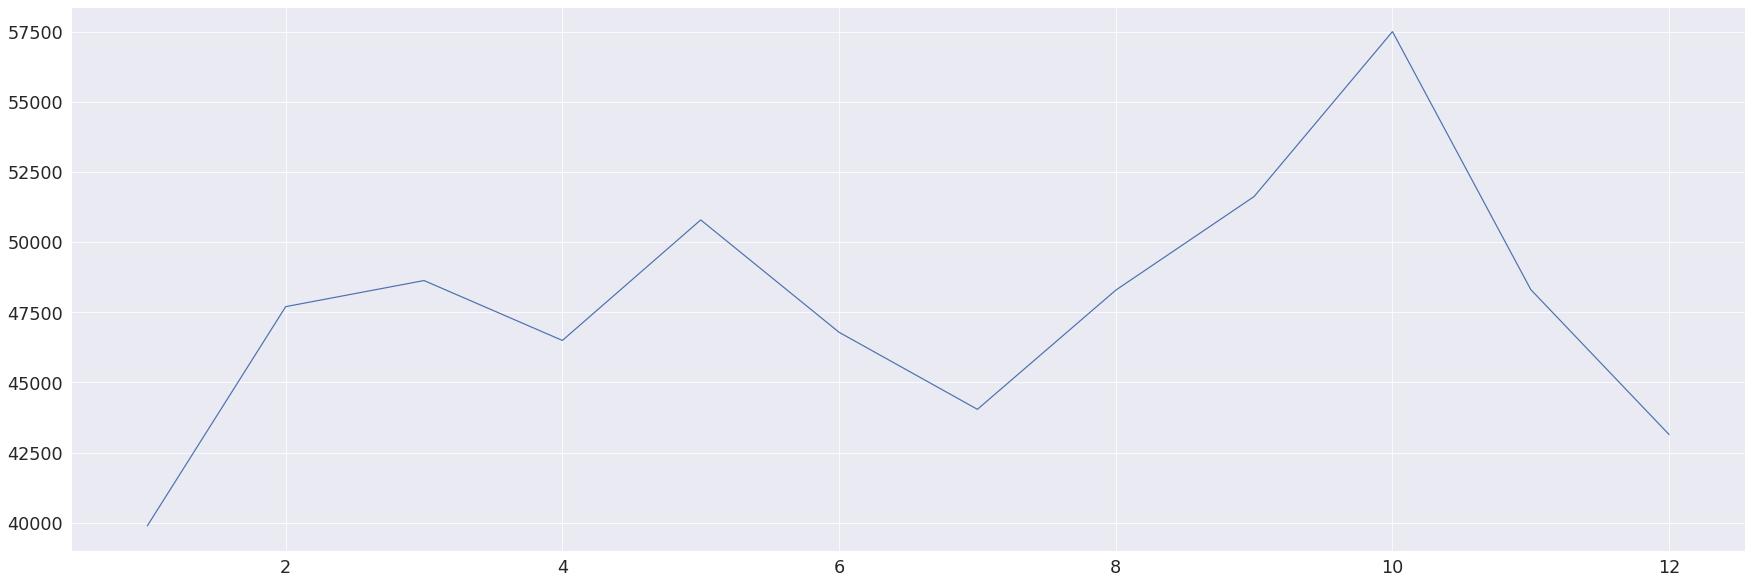

In [127]:
plt.figure(figsize=(30, 10))
plt.plot(crr_no['mes_solicitud'].value_counts().sort_index())

### El caso de los satisfactorios

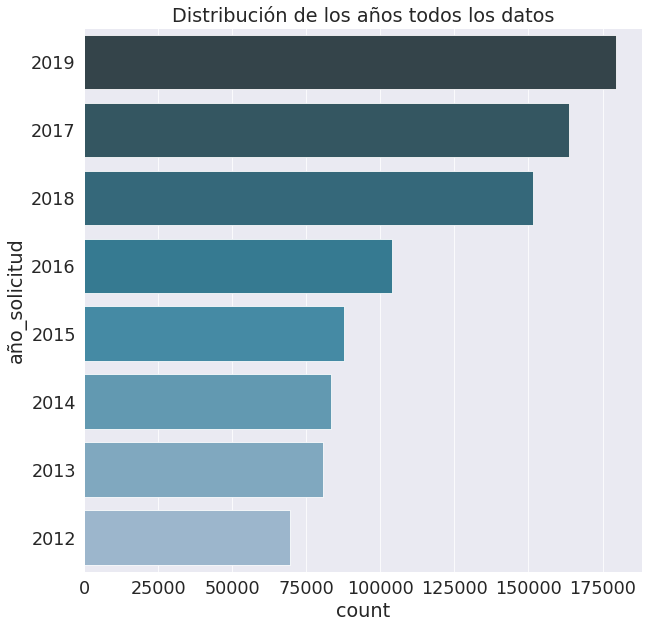

In [128]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(10, 10))
plt.title("Distribución de los años todos los datos")
ax = sns.countplot(y="año_solicitud", data=cr_si,order = cr_si['año_solicitud'].value_counts().index, palette="PuBuGn_d")

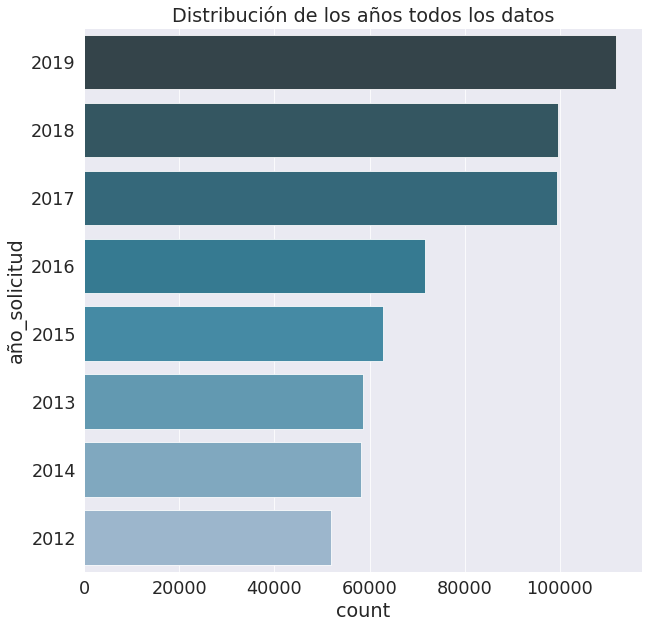

In [129]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(10, 10))
plt.title("Distribución de los años todos los datos")
ax = sns.countplot(y="año_solicitud", data=crr_si,order = crr_si['año_solicitud'].value_counts().index, palette="PuBuGn_d")

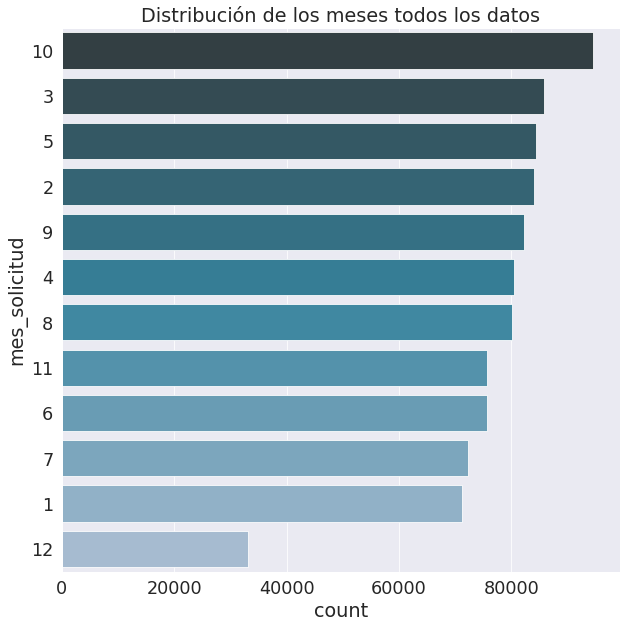

In [130]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(10, 10))
plt.title("Distribución de los meses todos los datos")
ax = sns.countplot(y="mes_solicitud", data=cr_si,order = cr_si['mes_solicitud'].value_counts().index, palette="PuBuGn_d")

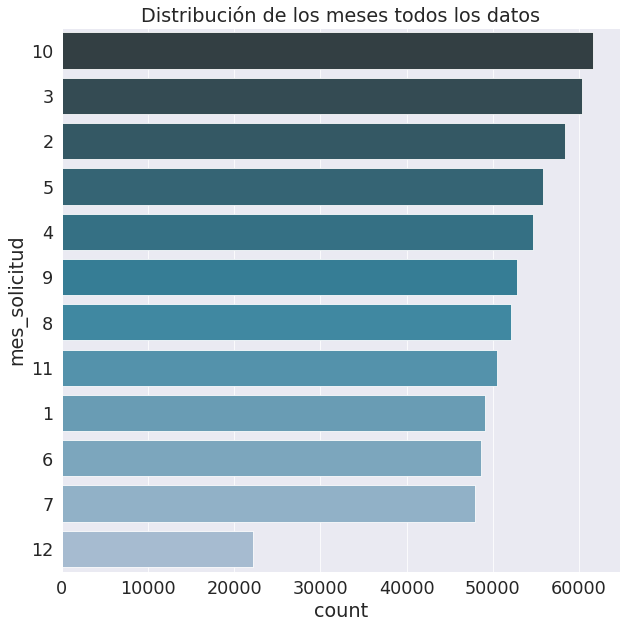

In [131]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=2)     
plt.figure(figsize=(10, 10))
plt.title("Distribución de los meses todos los datos")
ax = sns.countplot(y="mes_solicitud", data=crr_si,order = crr_si['mes_solicitud'].value_counts().index, palette="PuBuGn_d")

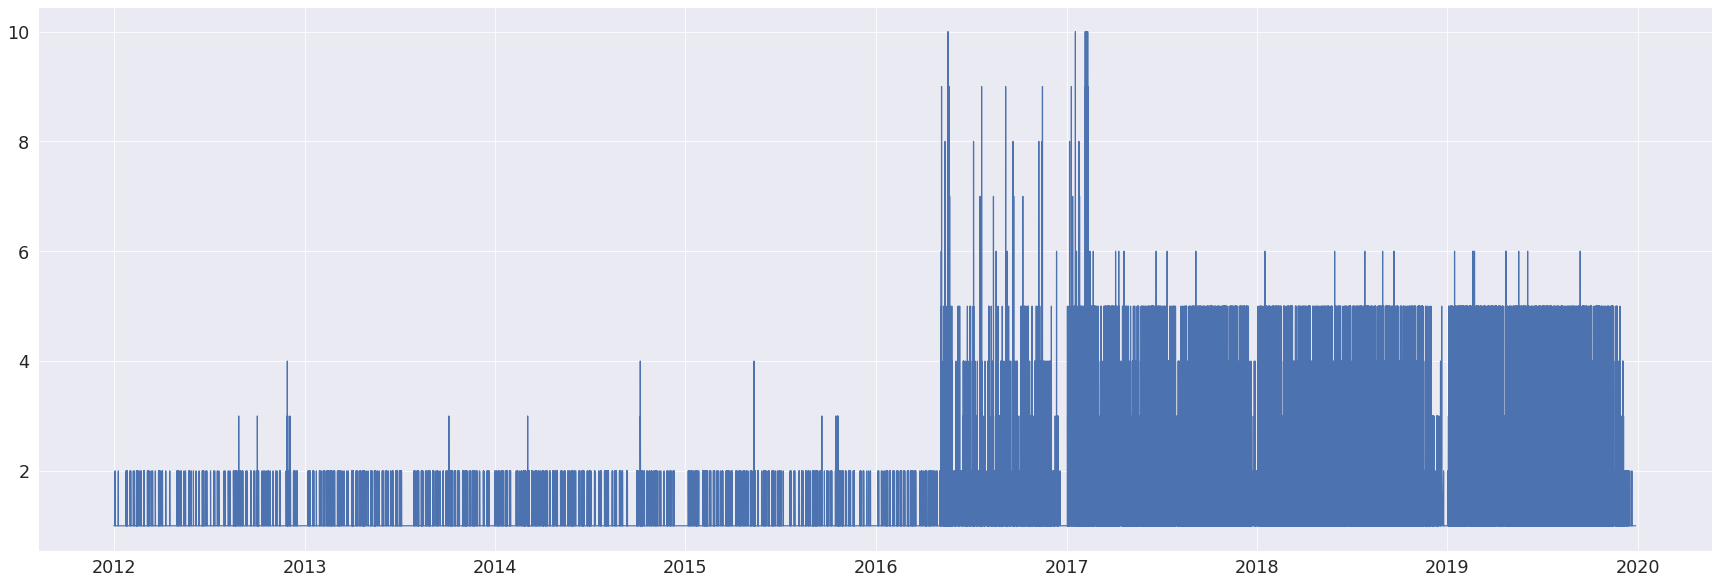

In [132]:
plt.figure(figsize=(30, 10))
plt.plot(cr_si['fechasolicitud'].value_counts().sort_index())

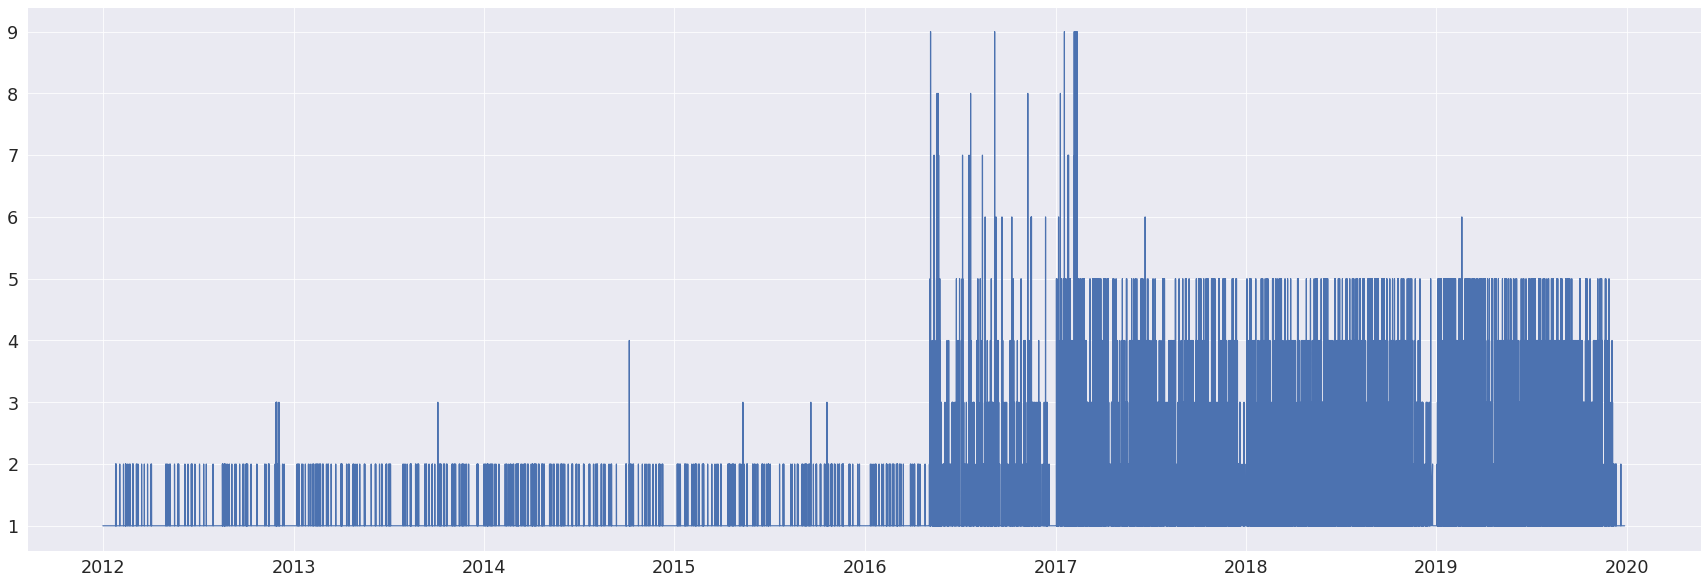

In [133]:
plt.figure(figsize=(30, 10))
plt.plot(crr_si['fechasolicitud'].value_counts().sort_index())

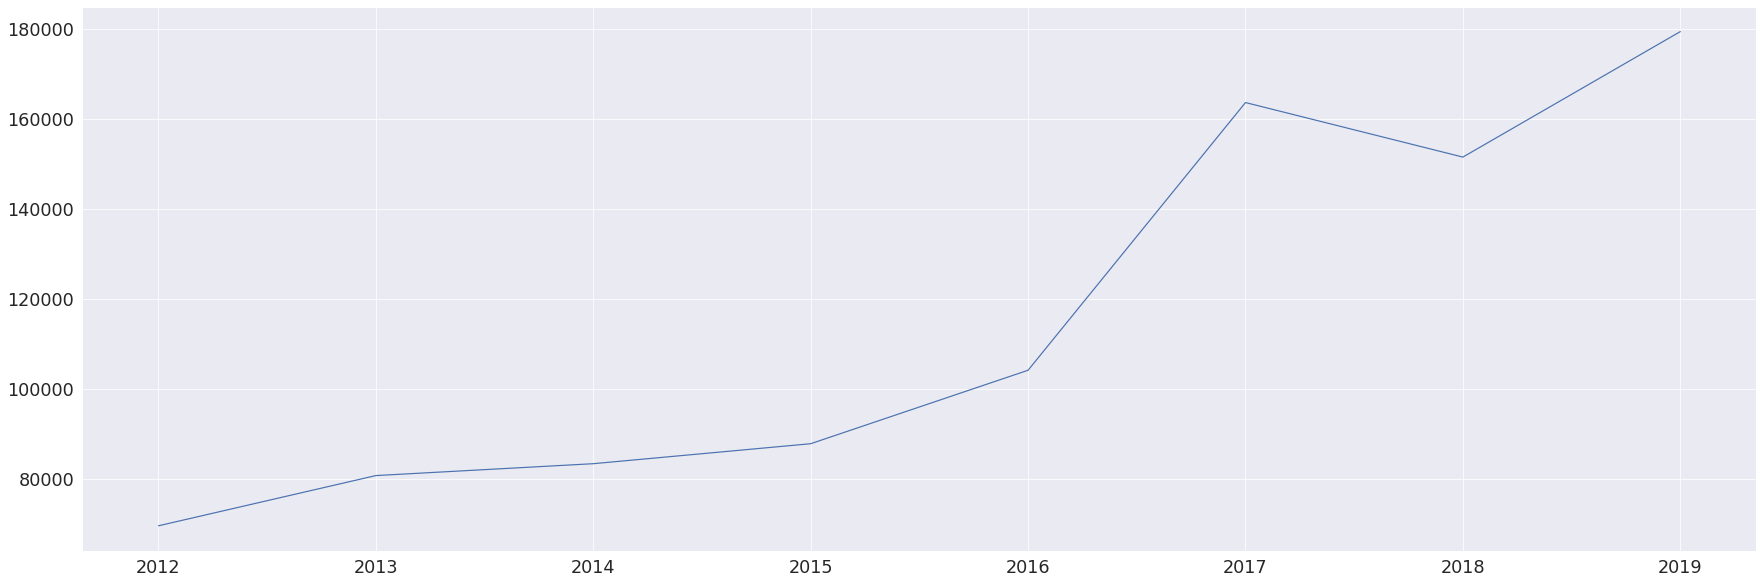

In [134]:
plt.figure(figsize=(30, 10))
plt.plot(cr_si['año_solicitud'].value_counts().sort_index())

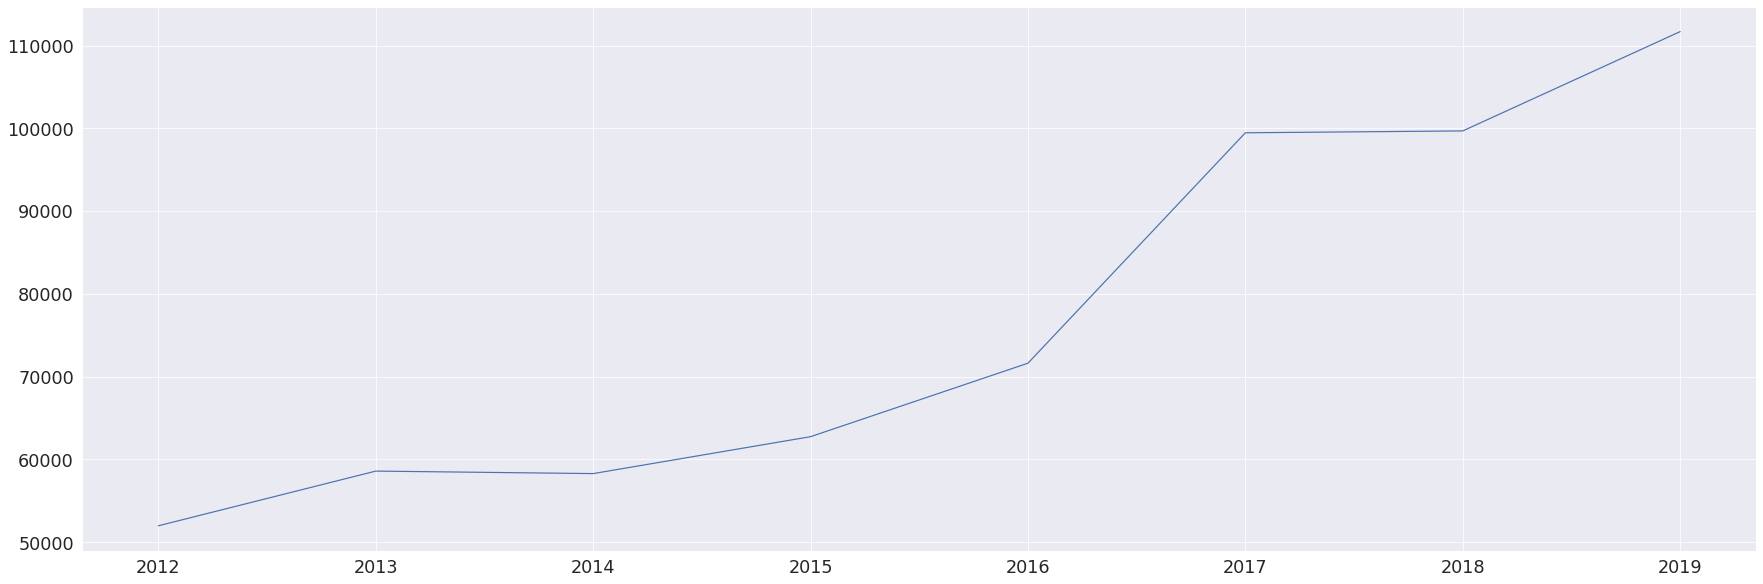

In [135]:
plt.figure(figsize=(30, 10))
plt.plot(crr_si['año_solicitud'].value_counts().sort_index())

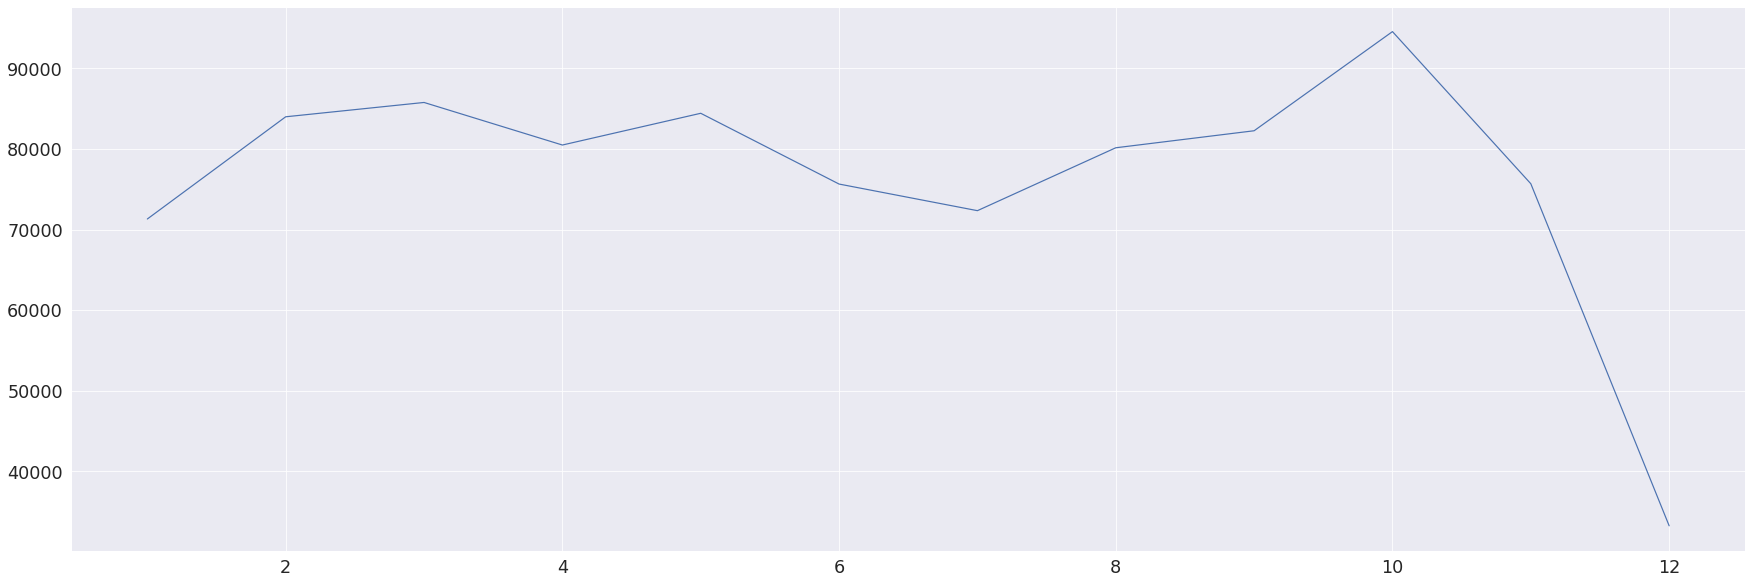

In [136]:
plt.figure(figsize=(30, 10))
plt.plot(cr_si['mes_solicitud'].value_counts().sort_index())

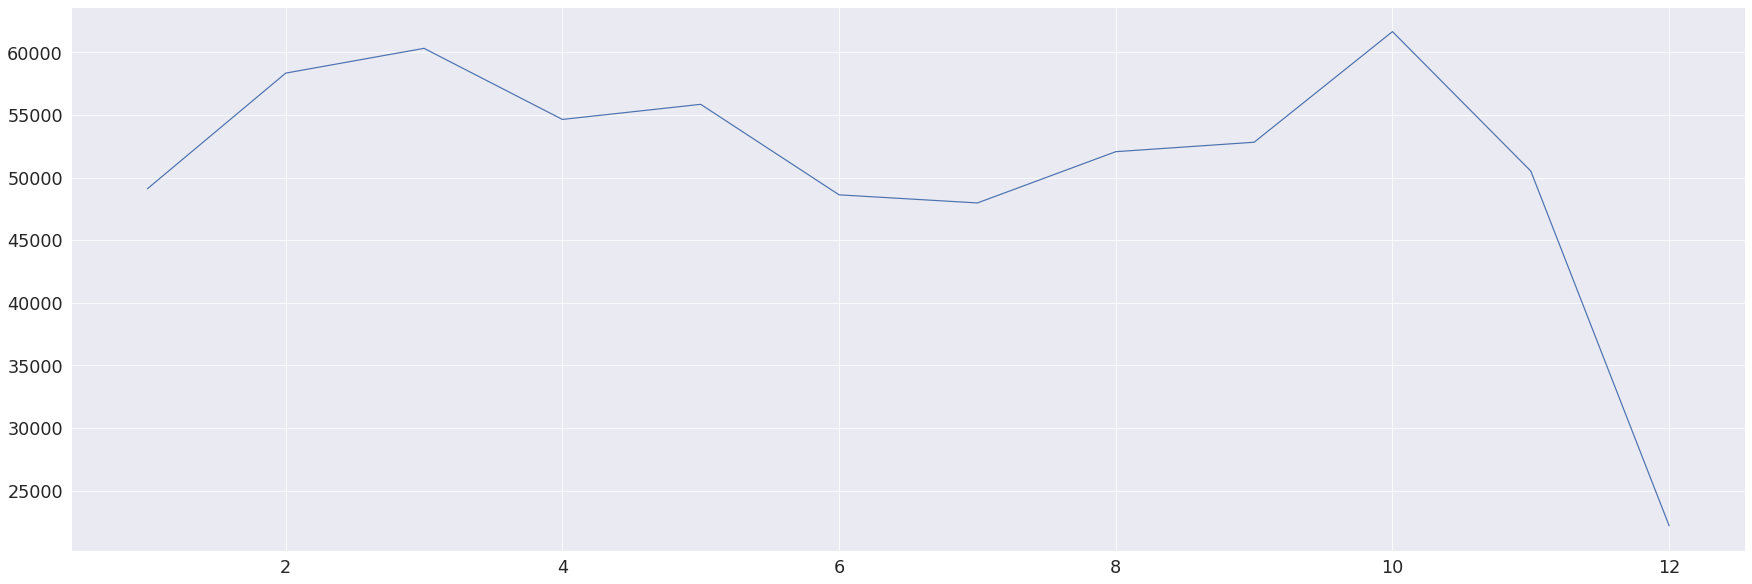

In [137]:
plt.figure(figsize=(30, 10))
plt.plot(crr_si['mes_solicitud'].value_counts().sort_index())

## Tiempo contra dependencia

In [174]:
#fig, ax = plt.subplots()
#ax.xaxis_date()
#for name, group in df_nuevo.groupby('dependencia_clean', sort=False):
#
#    group.amin = group['fechasolicitud'].iloc[0] # assume sorted order
#    group.amax = group['fechasolicitud'].iloc[1]
#
#    ax.hlines(group.index, dt.date2num(group.amin), dt.date2num(group.amax))

#plt.show()

In [175]:
#grafica = df_nuevo.groupby(['fechasolicitud', 'dependencia_clean']).agg({'n':'sum'}).reset_index()
#grafica.columns = ['mes_solicitud', 'dependencia_clean', 'n']
#grafica['calidad_respuesta'] = 'no respondida'
#grafica.head()
# df_nuevo.groupby(['dependencia_clean', 'calidad_respuesta']).size().unstack().plot(kind='bar', stacked=True,figsize=(30,10))

In [176]:
#grafica = df_nuevo.groupby(['fechasolicitud', 'calidad_respuesta']).agg({'n':'sum'}).reset_index()

In [147]:
import matplotlib.dates as dt

In [161]:
grpd = df_nuevo.groupby('dependencia_clean')
#grpd.head(5)
plot_data = pd.DataFrame({'start': dt.date2num(pd.to_datetime(grpd.min().fechasolicitud)), 'stop':  dt.date2num(pd.to_datetime(grpd.max().fechasolicitud))}, grpd.min().index)

In [162]:
plot_data -= plot_data.start.min() - 1
plot_data['duration'] = plot_data.stop - plot_data.start

In [163]:
cr_proceso = df_nuevo[df_nuevo['calidad_respuesta']=='en proceso']
cr_no = df_nuevo[df_nuevo['calidad_respuesta']=='no respondida']
cr_si = df_nuevo[df_nuevo['calidad_respuesta']=='satisfactoria']
crr_proceso = df_nuevo[df_nuevo['calidad_respuesta_real']=='en proceso']
crr_no = df_nuevo[df_nuevo['calidad_respuesta_real']=='no respondida']
crr_si = df_nuevo[df_nuevo['calidad_respuesta_real']=='satisfactoria']

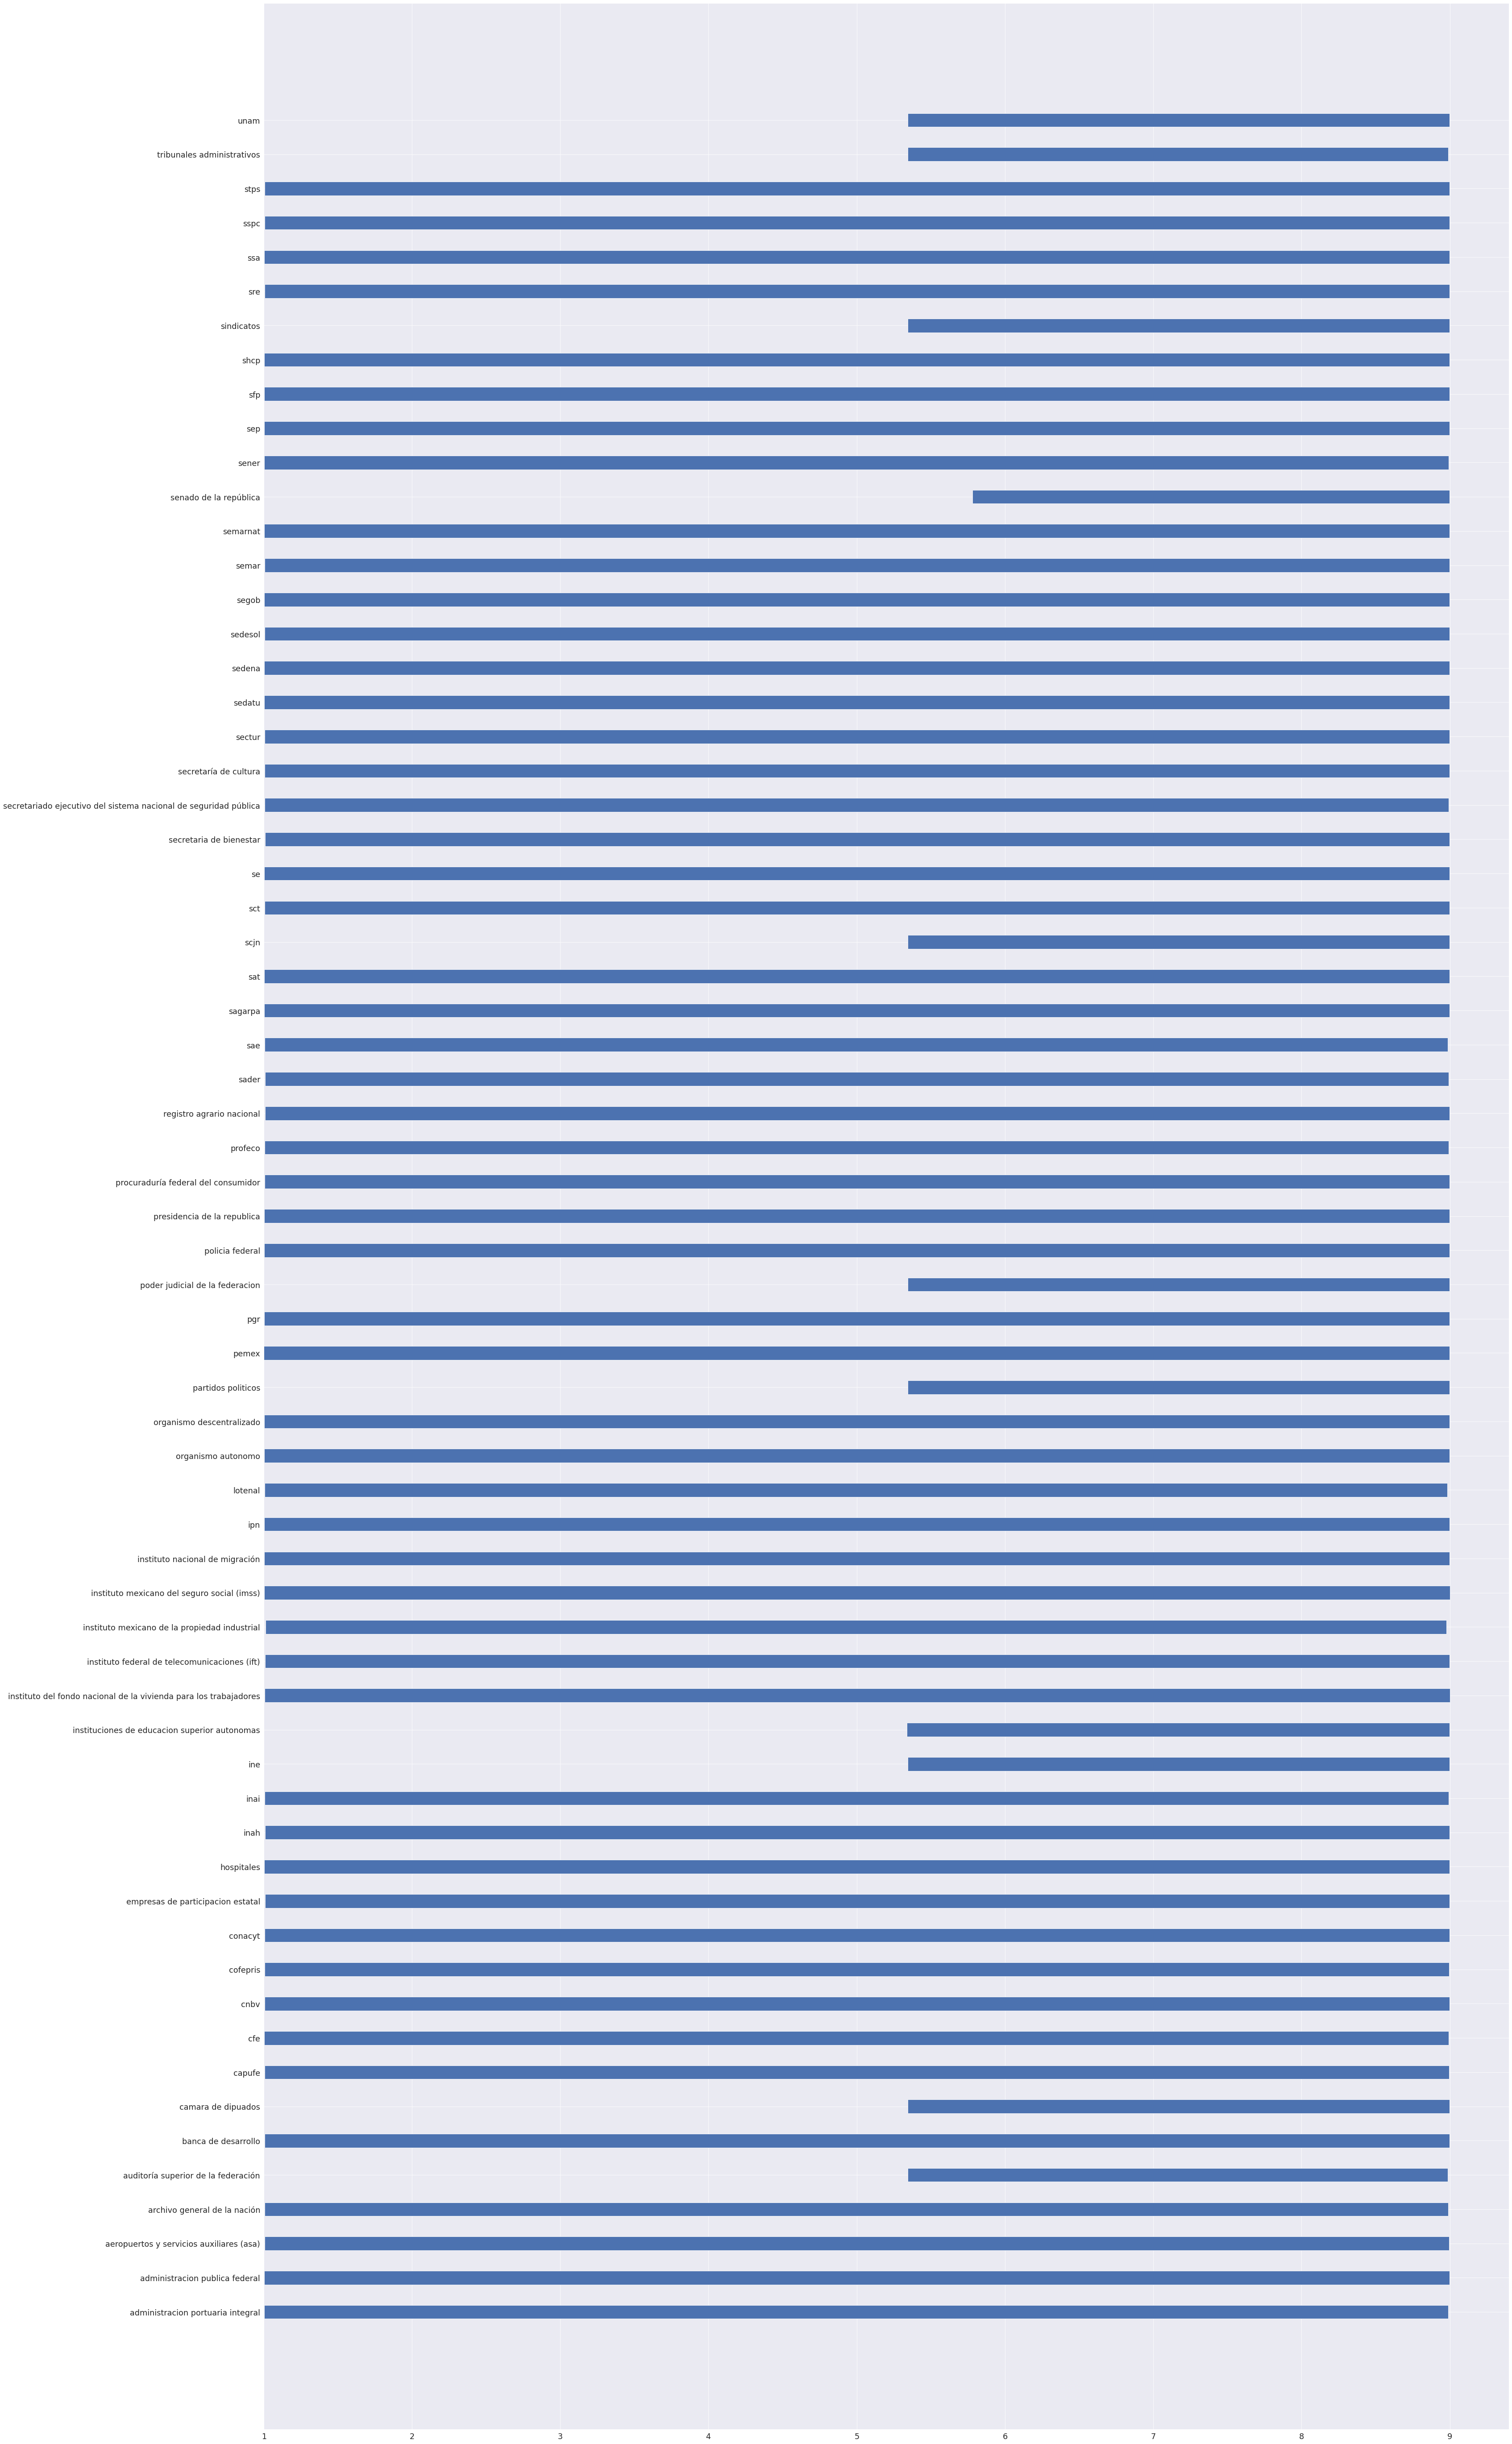

<Figure size 3600x7200 with 0 Axes>

In [164]:
fig, ax = plt.subplots(figsize=(50,100))
ax.xaxis_date()
plt.figure(figsize=(50, 100))
ax.barh(plot_data.index, plot_data.duration, left=plot_data.start, height=.4)
plt.tight_layout()

### no respondidas:

In [165]:
grpd_cr_no = cr_no.groupby('dependencia_clean')
#grpd.head(5)
plot_data = pd.DataFrame({'start': dt.date2num(pd.to_datetime(grpd_cr_no.min().fechasolicitud)), 'stop':  dt.date2num(pd.to_datetime(grpd_cr_no.max().fechasolicitud))}, grpd_cr_no.min().index)

In [166]:
plot_data -= plot_data.start.min() - 1
plot_data['duration'] = plot_data.stop - plot_data.start

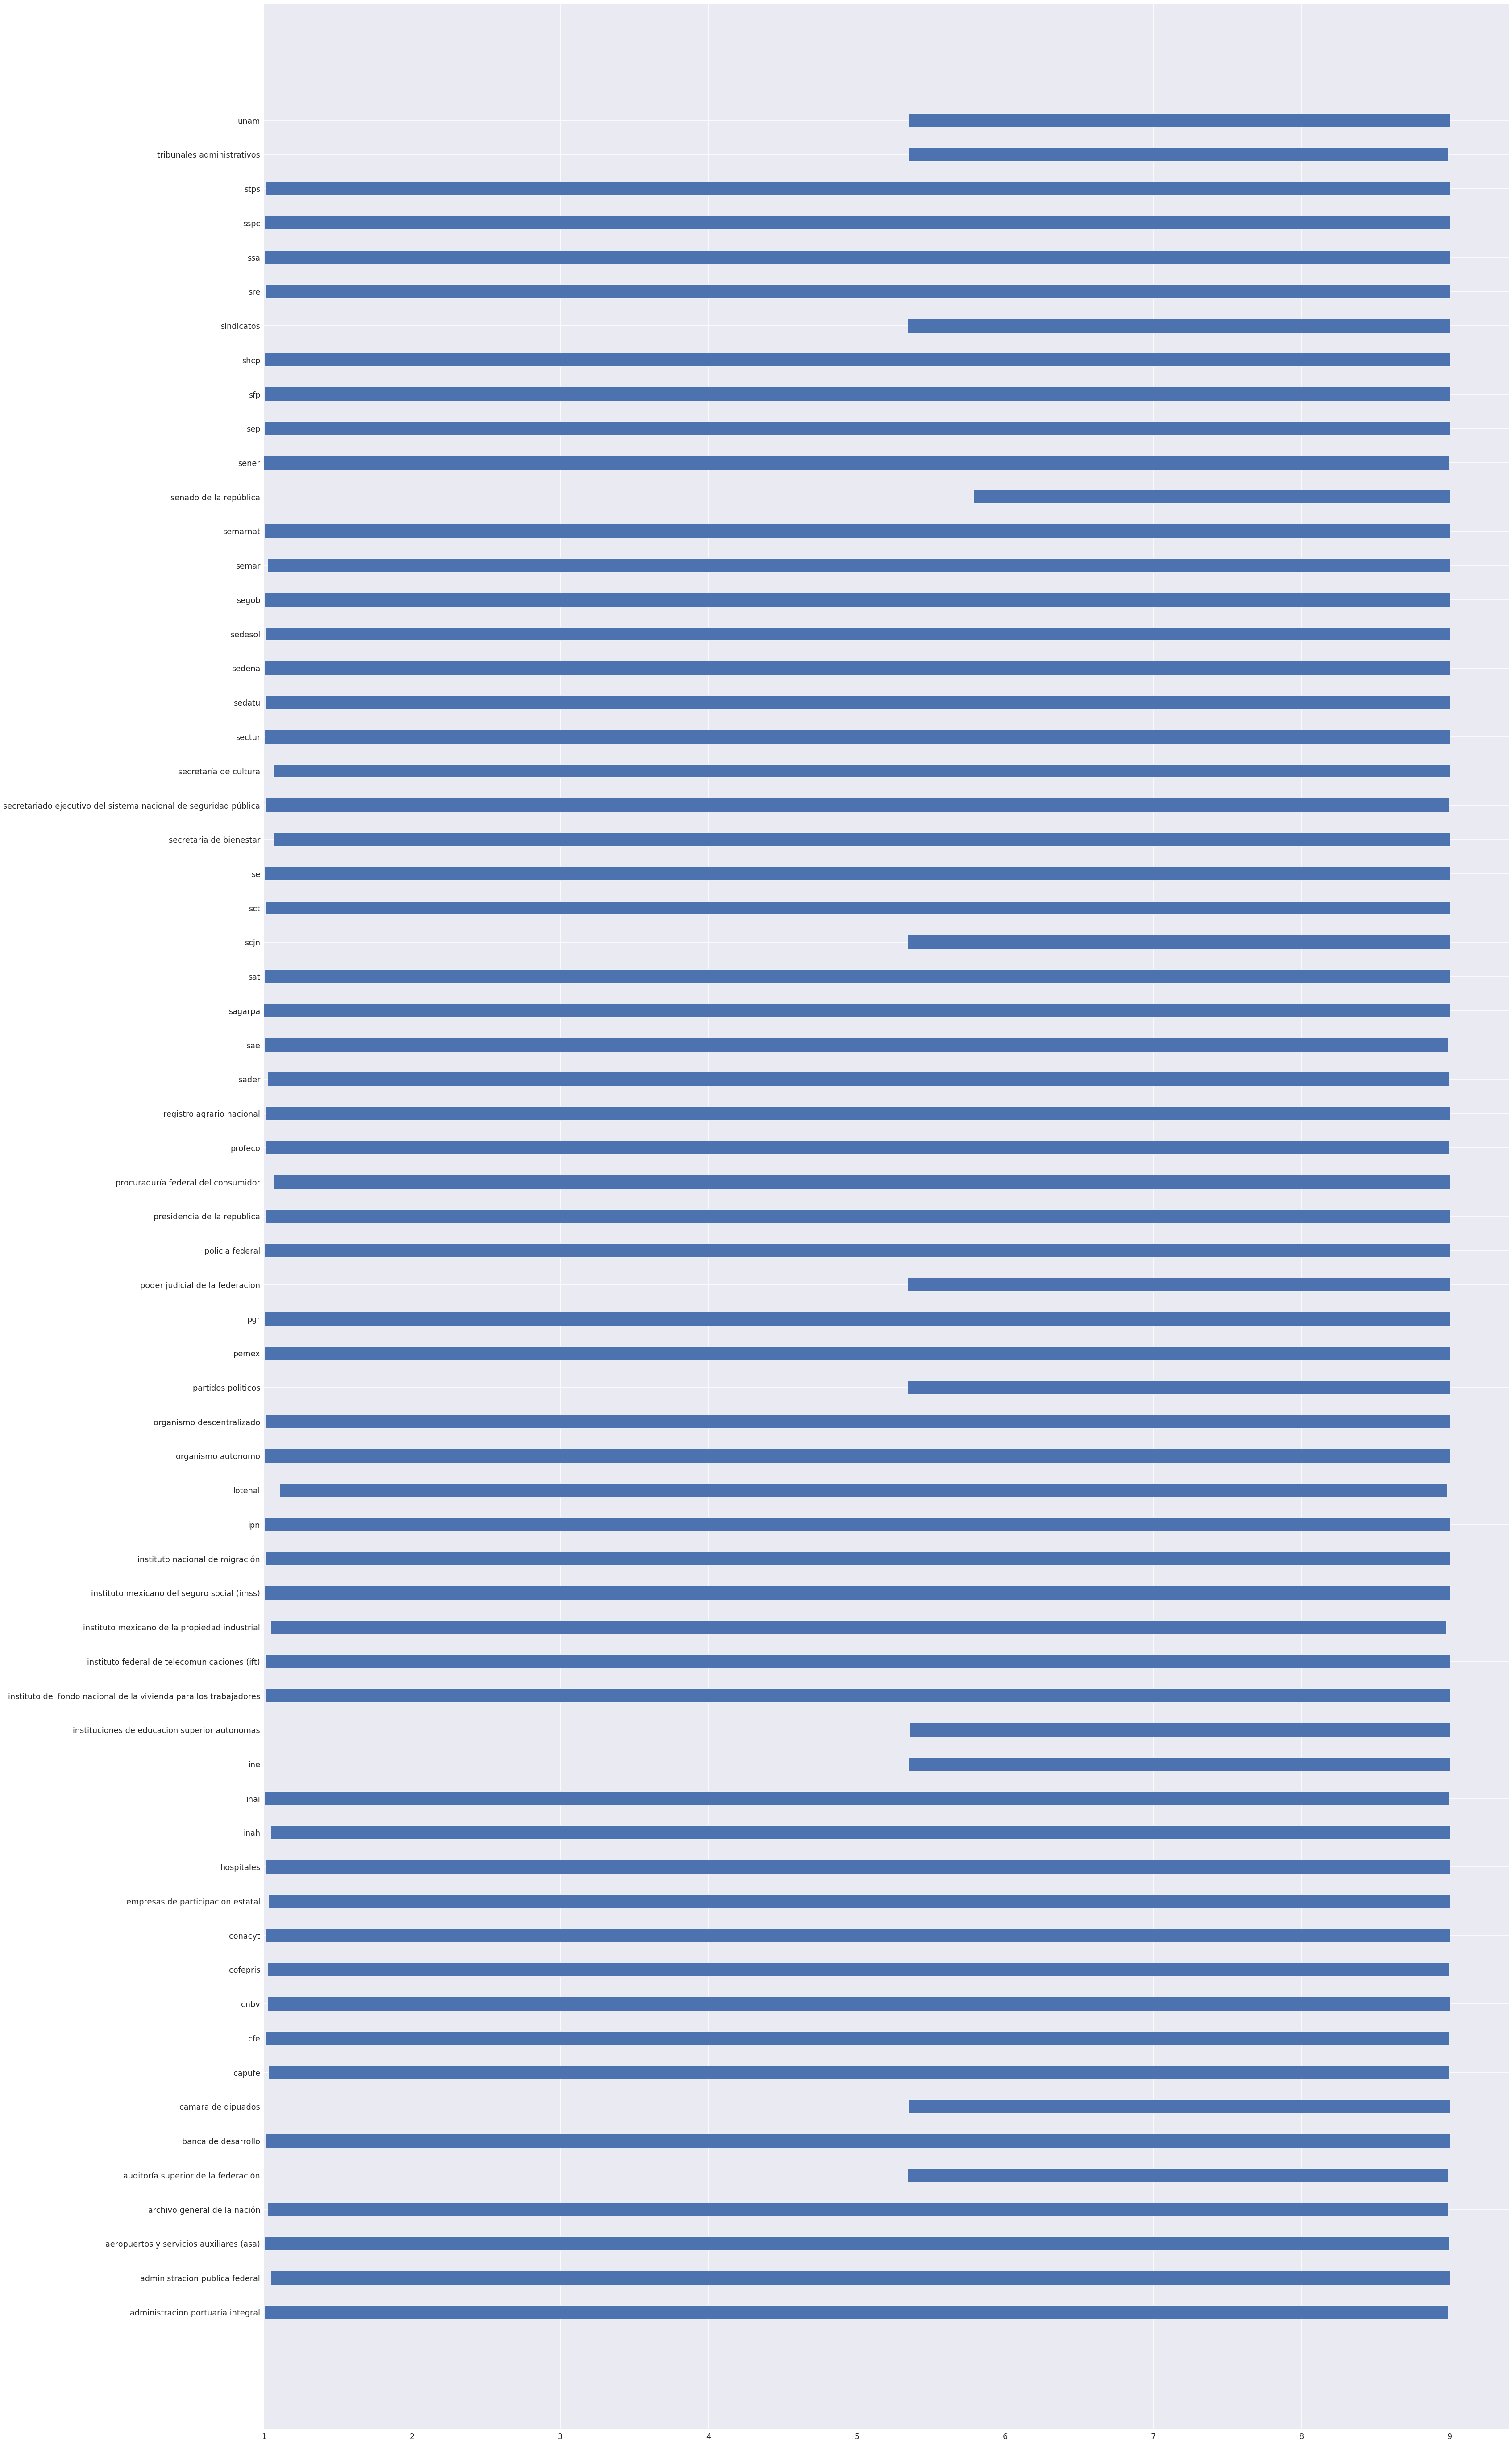

<Figure size 3600x7200 with 0 Axes>

In [167]:
fig, ax = plt.subplots(figsize=(50,100))
ax.xaxis_date()
plt.figure(figsize=(50, 100))
ax.barh(plot_data.index, plot_data.duration, left=plot_data.start, height=.4)
plt.tight_layout()

### si respondidas

In [171]:
grpd_cr_si = cr_si.groupby('dependencia_clean')
#grpd.head(5)
plot_data = pd.DataFrame({'start': dt.date2num(pd.to_datetime(grpd_cr_si.min().fechasolicitud)), 'stop':  dt.date2num(pd.to_datetime(grpd_cr_si.max().fechasolicitud))}, grpd_cr_si.min().index)

In [172]:
plot_data -= plot_data.start.min() - 1
plot_data['duration'] = plot_data.stop - plot_data.start

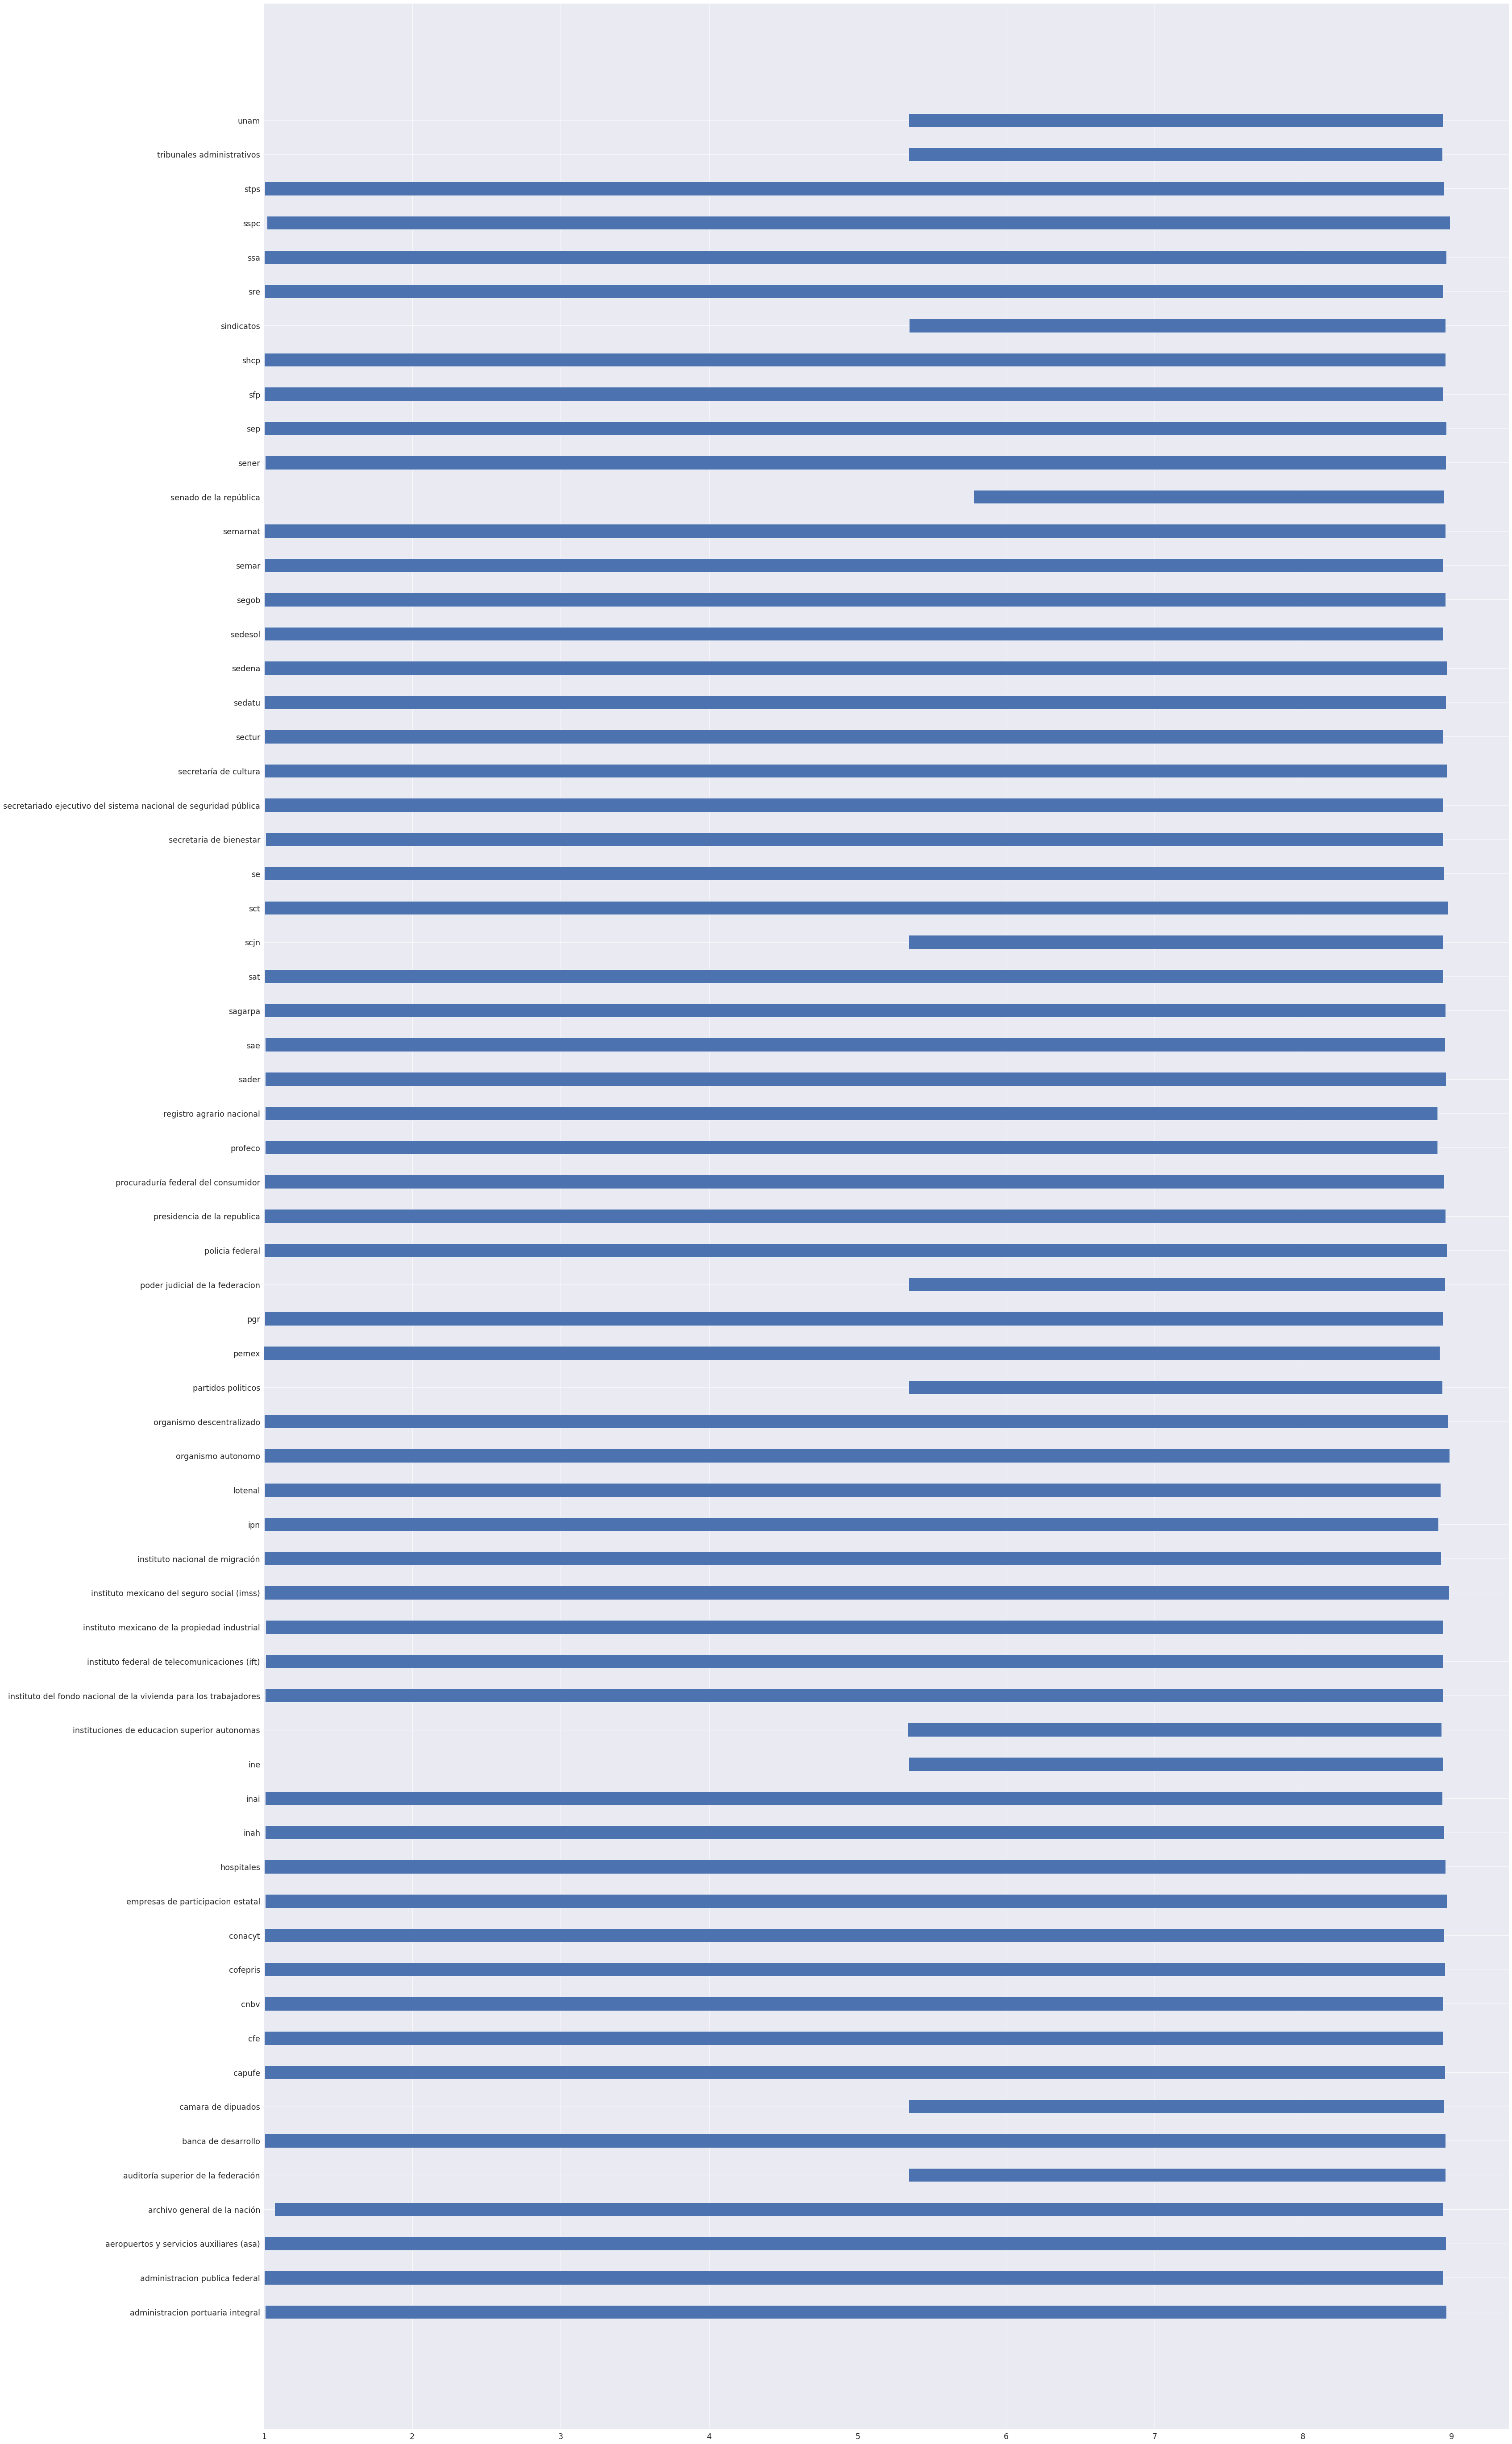

<Figure size 3600x7200 with 0 Axes>

In [173]:
fig, ax = plt.subplots(figsize=(50,100))
ax.xaxis_date()
plt.figure(figsize=(50, 100))
ax.barh(plot_data.index, plot_data.duration, left=plot_data.start, height=.4)
plt.tight_layout()

In [179]:
df_graf_nuevo = pd.DataFrame(df_nuevo, index=df_nuevo.fechasolicitud.index, columns=list('dependencia_clean'))
df_comsum = df_nuevo.cumsum()
plt.figure();
df.plot();

ValueError: Wrong number of items passed 1249668, placement implies 3

AttributeError: 'Line2D' object has no property 'xlabel'

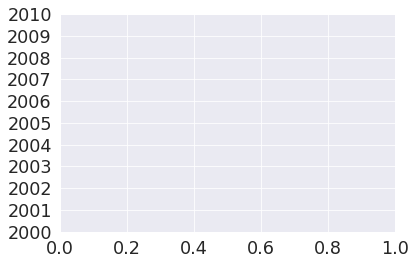

In [184]:
#df.plot(subplots=True, figsize=(6, 6));
cr_no.plot(xlabel="fechasolicitud", ylabel=cr_si['dependencia_clean'].value_counts().sort_index())

In [188]:
df_nuevo['dependencia_clean'].plot(subplots=True, figsize=(20, 30));

TypeError: no numeric data to plot

In [ ]:
cr_no_ext = [[]]

In [ ]:
cr_no.plot()


In [189]:
ctdf = (cr_no.reset_index()
          .groupby(['fechasolicitud','dependencia_clean'], as_index=False)
          .count()
          # rename isn't strictly necessary here, it's just for readability
          .rename(columns={'index':'ct'})
       )

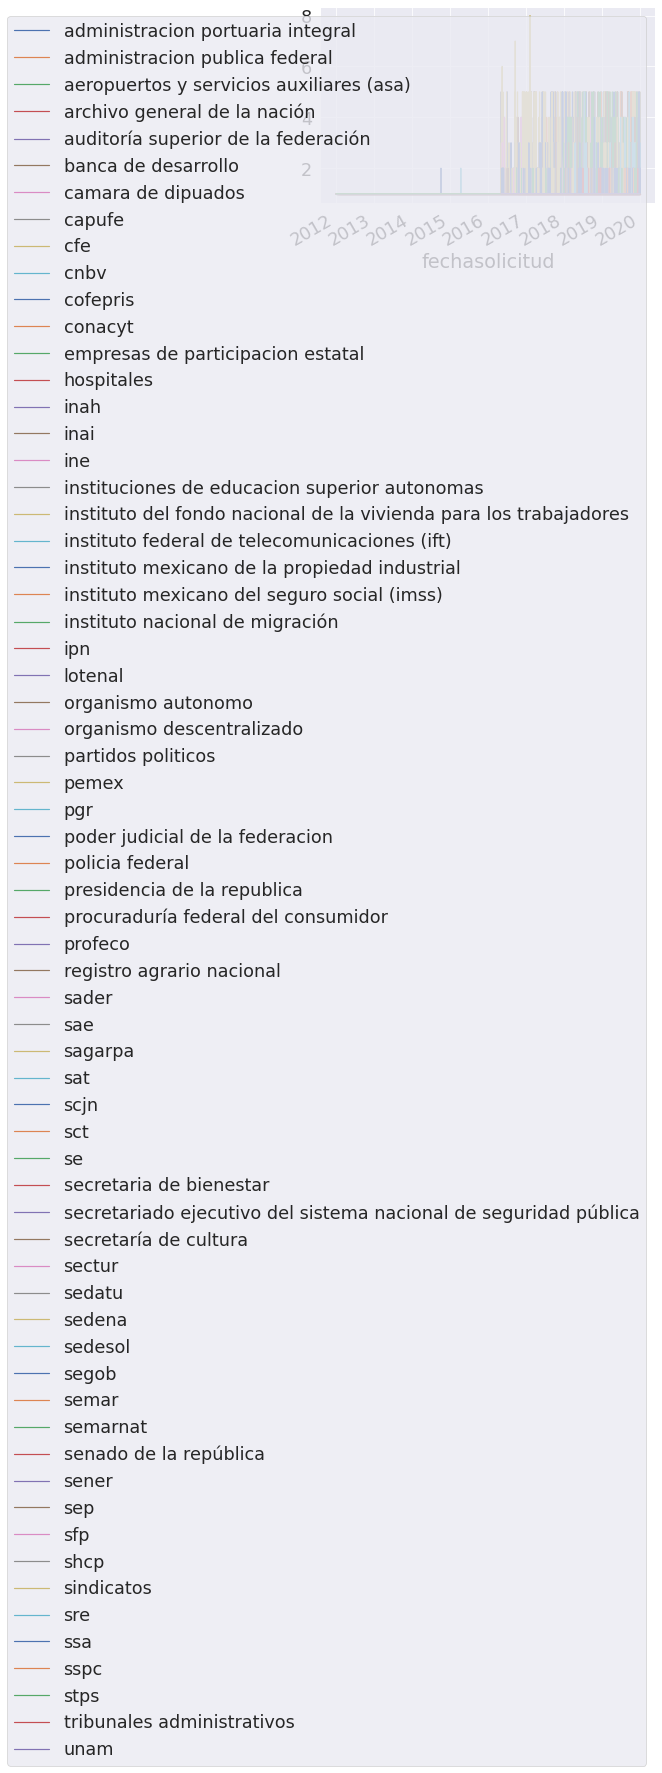

<Figure size 7200x7200 with 0 Axes>

In [204]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
plt.figure(figsize=(100, 100))

for key, data in ctdf.groupby('dependencia_clean'):
    data.plot(x='fechasolicitud', y='ct', ax=ax, label=key)

In [192]:
cr_no.groupby(["fechasolicitud","dependencia_clean"]).count()

In [197]:
cr_no.head()

,folio,fechasolicitud,dependencia,estatus,medioentrada,tiposolicitud,descripcionsolicitud,otrosdatos,archivoadjuntosolicitud,medioentrega,...,sector,tipo_archivo_respuesta,cantidad_archivos_respuesta,texto_respuesta_adjunto,respuestareal,calidad_respuesta,calidad_respuesta_real,dependencia_clean,año_solicitud,mes_solicitud
2,0001800000712,2012-01-01 09:46:39,secretaria de energia,terminada,electronica,informacion publica,se me proporcione en magnetico y por este medi...,None,None,entrega por internet en el infomex,...,energia,zip,2.0,None,inexistencia de la informacion solicitada,no respondida,no respondida,sener,2012,1
9,0000800001412,2012-01-01 11:41:37,secretaria de agricultura ganaderia desarrollo...,terminada,electronica,informacion publica,se me proporciones en magnetico y por este med...,None,None,entrega por internet en el infomex,...,"agricultura, ganaderia, desarrollo rural, pesc...",None,NaN,None,no es de competencia de la unidad de enlace,no respondida,no respondida,sagarpa,2012,1
10,0000800001512,2012-01-01 11:47:43,secretaria de agricultura ganaderia desarrollo...,terminada,electronica,informacion publica,se me proporciones en magnetico y por este med...,None,None,entrega por internet en el infomex,...,"agricultura, ganaderia, desarrollo rural, pesc...",None,NaN,None,no es de competencia de la unidad de enlace,no respondida,no respondida,sagarpa,2012,1
17,0917600000212,2012-01-01 14:02:55,administracion portuaria integral de altamira ...,terminada,electronica,informacion publica,solicito se me proporcione por medio los docum...,y de manera mas especifica los documentos que ...,None,entrega por internet en el infomex,...,comunicaciones y transportes,None,NaN,None,no es de competencia de la unidad de enlace,no respondida,no respondida,administracion portuaria integral,2012,1
19,0918000000112,2012-01-01 14:07:44,administracion portuaria integral de dos bocas...,terminada,electronica,informacion publica,solicito se me proporcione por medio los docum...,y de manera mas especifica los documentos que ...,None,entrega por internet en el infomex,...,comunicaciones y transportes,None,NaN,None,no es de competencia de la unidad de enlace,no respondida,no respondida,administracion portuaria integral,2012,1


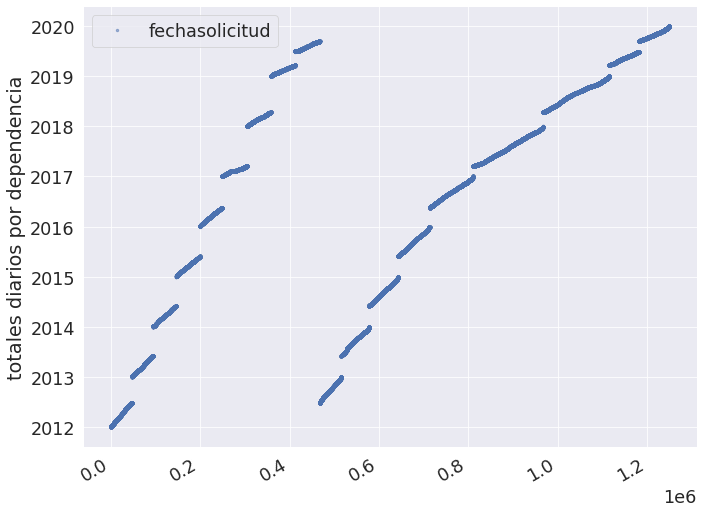

In [196]:
cols_plot = ['dependencia_clean', 'fechasolicitud']
axes = cr_no[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('totales diarios por dependencia')